In [106]:
# Notebook 03: Measurement Invariance Testing
# Tests whether the validated AIRS scale functions equivalently across demographic groups
# Input: Full sample + validated scale from Notebook 02
# Output: Invariance results for moderation analyses

print("1. Importing standard libraries...")
import sys
import os

# CRITICAL FIX: Prevent OpenMP runtime conflicts causing kernel crashes/freezes
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import json
import warnings
from pathlib import Path

print("2. Importing numpy/pandas...")
# Check if already imported to avoid re-initialization hangs
if 'numpy' not in sys.modules:
    import numpy as np
else:
    np = sys.modules['numpy']
    print("  (numpy already imported)")

if 'pandas' not in sys.modules:
    import pandas as pd
else:
    pd = sys.modules['pandas']
    print("  (pandas already imported)")

print("3. Importing matplotlib/seaborn...")
import matplotlib.pyplot as plt
import seaborn as sns

print("4. Importing semopy...")
from semopy import Model
import semopy

print("5. Configuring environment...")
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configure APA-style plotting (apply once for all figures)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'

print("="*70)
print("NOTEBOOK 03: MEASUREMENT INVARIANCE TESTING")
print("="*70)
print("Purpose: Test measurement equivalence across demographic groups")
print(f"Working directory: {Path.cwd()}")

1. Importing standard libraries...
2. Importing numpy/pandas...
  (numpy already imported)
  (pandas already imported)
3. Importing matplotlib/seaborn...
4. Importing semopy...
5. Configuring environment...
NOTEBOOK 03: MEASUREMENT INVARIANCE TESTING
Purpose: Test measurement equivalence across demographic groups
Working directory: c:\Development\AIRS_Data_Analysis\airs


## 1. Load Data and Item Selection

In [107]:
# Load full dataset
df = pd.read_csv('../data/AIRS_clean.csv')

print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Total sample: N = {len(df)}")
print(f"Variables: {len(df.columns)}")

DATA LOADED
Total sample: N = 278
Variables: 45


In [108]:
# Load validated scale structure from Notebook 02
# These 12 items represent the final validated UTAUT2 subscales (6 constructs × 2 items)
selected_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 
                  'FC1', 'FC2', 'HM1', 'HM2', 'PV1', 'PV2']

print("="*70)
print("VALIDATED SCALE (FROM NOTEBOOK 02)")
print("="*70)
print(f"Structure: 6 UTAUT2 constructs × 2 items each")
print(f"Total items: {len(selected_items)}")
print("\nConstructs:")
constructs = {'PE': [], 'EE': [], 'SI': [], 'FC': [], 'HM': [], 'PV': []}
for item in selected_items:
    prefix = item[:2]
    if prefix in constructs:
        constructs[prefix].append(item)

for i, (construct, items) in enumerate(constructs.items(), 1):
    print(f"  {i}. {construct}: {', '.join(items)}")
print("\nValidation source: Notebook 02 CFA")

# Define 6-factor model specification (matching validated structure)
model_spec_6factor = """
# UTAUT2 6-Factor Measurement Model
PE =~ PE1 + PE2
EE =~ EE1 + EE2
SI =~ SI1 + SI2
FC =~ FC1 + FC2
HM =~ HM1 + HM2
PV =~ PV1 + PV2
"""

# Also keep single-factor for comparison (sensitivity analysis)
model_spec_1factor = f"""
# Single-factor model (for comparison)
AI_Readiness =~ {' + '.join(selected_items)}
"""

print("\n" + "="*70)
print("MODEL SPECIFICATIONS")
print("="*70)
print("\nPRIMARY: 6-Factor UTAUT2 Model (from validated CFA)")
print(model_spec_6factor)
print("\nSECONDARY: Single-factor model (sensitivity check)")
print(f"  AI_Readiness =~ {len(selected_items)} items")

VALIDATED SCALE (FROM NOTEBOOK 02)
Structure: 6 UTAUT2 constructs × 2 items each
Total items: 12

Constructs:
  1. PE: PE1, PE2
  2. EE: EE1, EE2
  3. SI: SI1, SI2
  4. FC: FC1, FC2
  5. HM: HM1, HM2
  6. PV: PV1, PV2

Validation source: Notebook 02 CFA

MODEL SPECIFICATIONS

PRIMARY: 6-Factor UTAUT2 Model (from validated CFA)

# UTAUT2 6-Factor Measurement Model
PE =~ PE1 + PE2
EE =~ EE1 + EE2
SI =~ SI1 + SI2
FC =~ FC1 + FC2
HM =~ HM1 + HM2
PV =~ PV1 + PV2


SECONDARY: Single-factor model (sensitivity check)
  AI_Readiness =~ 12 items


## 2. Define Grouping Variables

Tests measurement equivalence across demographic dimensions for moderation hypotheses.

**Invariance Levels** (Vandenberg & Lance, 2000):
- **Configural**: Same factor structure across groups (baseline)
- **Metric**: Equal factor loadings across groups (weak invariance)
- **Scalar**: Equal item intercepts across groups (strong invariance)

**Decision Criteria** (Cheung & Rensvold, 2002; Chen, 2007):
- Configural: CFI ≥ 0.90, RMSEA ≤ 0.08
- Metric: ΔCFI ≤ 0.010 from configural model
- Scalar: ΔCFI ≤ 0.010 from metric model

**Minimum Sample Size** (Wolf et al., 2013):
- N ≥ 100 per group recommended for stable estimates

**⚠️ Methodological Note**: 
This analysis uses semopy which does not support native multi-group CFA with equality constraints. 
Results are therefore **descriptive approximations** using separate-group CFAs and magnitude-based comparisons.
Formal invariance testing would require lavaan (R), Mplus, or AMOS with nested model χ² difference tests.

In [109]:
# Group 1: Role (Student vs. Professional)
# Combine Academic-Faculty and Professional into "Professional"
df['Role_Binary'] = df['Work_Context'].apply(
    lambda x: 'Student' if x == 'Academic-Student' else 'Professional'
)

print("="*70)
print("GROUP 1: ROLE")
print("="*70)
role_counts = df['Role_Binary'].value_counts()
print(role_counts)
for category in role_counts.index:
    print(f"\n{category} %: {role_counts[category]/len(df)*100:.1f}%")

if len(role_counts) < 2:
    print(f"\n⚠️ WARNING: Only {len(role_counts)} role category present in subsample.")
    print("   Role-based invariance testing requires both Student and Professional groups.")
    print("   Skipping role invariance tests.")

GROUP 1: ROLE
Role_Binary
Professional    278
Name: count, dtype: int64

Professional %: 100.0%

⚠️ WARNING: Only 1 role category present in subsample.
   Role-based invariance testing requires both Student and Professional groups.
   Skipping role invariance tests.


In [110]:
# Group 2: AI Usage Frequency (Low vs. High)
# Based on Usage_Intensity (combine Non-User+Low vs. Medium+High)
df['Usage_Binary'] = df['Usage_Intensity'].apply(
    lambda x: 'Low' if x in ['Non-User', 'Low'] else 'High'
)

print("="*70)
print("GROUP 2: AI USAGE FREQUENCY")
print("="*70)
usage_counts = df['Usage_Binary'].value_counts()
print(usage_counts)
for category in usage_counts.index:
    print(f"\n{category} %: {usage_counts[category]/len(df)*100:.1f}%")

if len(usage_counts) < 2:
    print(f"\n⚠️ WARNING: Only {len(usage_counts)} usage category present in subsample.")
    print("   Usage-based invariance testing requires both Low and High groups.")
    print("   Skipping usage invariance tests.")

GROUP 2: AI USAGE FREQUENCY
Usage_Binary
High    163
Low     115
Name: count, dtype: int64

High %: 58.6%

Low %: 41.4%


In [111]:
# Group 3: AI Adoption Status (Adopter vs. Non-adopter)
df['Adoption_Binary'] = df['AI_Adoption'].apply(
    lambda x: 'Adopter' if x == 1 else 'Non-Adopter'
)

print("="*70)
print("GROUP 3: AI ADOPTION STATUS")
print("="*70)
adoption_counts = df['Adoption_Binary'].value_counts()
print(adoption_counts)
for category in adoption_counts.index:
    print(f"\n{category} %: {adoption_counts[category]/len(df)*100:.1f}%")

if len(adoption_counts) < 2:
    print(f"\n⚠️ WARNING: Only {len(adoption_counts)} adoption category present in subsample.")
    print("   Adoption-based invariance testing requires both Adopter and Non-Adopter groups.")
    print("   Skipping adoption invariance tests.")

# ============================================================================
# SAMPLE SIZE ADEQUACY CHECK (Wolf et al., 2013)
# ============================================================================
print("\n" + "="*70)
print("SAMPLE SIZE ADEQUACY CHECK")
print("="*70)
print("Minimum recommended: N ≥ 100 per group (Wolf et al., 2013)")
print("N:parameter ratio should be ≥ 5:1 for stable estimates\n")

MIN_N_PER_GROUP = 100
n_parameters = 12 + 6 + 15  # 12 loadings + 6 factor variances + 15 factor covariances (6-factor model)

group_adequacy = []
for group_name, counts in [('Role', role_counts), ('Usage', usage_counts), ('Adoption', adoption_counts)]:
    min_n = counts.min() if len(counts) >= 2 else counts.iloc[0]
    is_adequate = min_n >= MIN_N_PER_GROUP
    ratio = min_n / n_parameters
    group_adequacy.append({
        'Grouping': group_name,
        'Min_N': min_n,
        'Adequate': is_adequate,
        'N:param': ratio
    })
    
    status = "✓ Adequate" if is_adequate else "⚠️ Underpowered"
    print(f"{group_name}:")
    print(f"  Smallest group N = {min_n}")
    print(f"  N:parameter ratio = {ratio:.1f}:1")
    print(f"  Status: {status}")
    print()

# Overall recommendation
all_adequate = all(g['Adequate'] for g in group_adequacy)
if all_adequate:
    print("✓ All grouping variables have adequate sample sizes for invariance testing")
else:
    underpowered = [g['Grouping'] for g in group_adequacy if not g['Adequate']]
    print(f"⚠️ WARNING: {', '.join(underpowered)} may be underpowered")
    print("   Results should be interpreted with caution")

GROUP 3: AI ADOPTION STATUS
Adoption_Binary
Adopter        239
Non-Adopter     39
Name: count, dtype: int64

Adopter %: 86.0%

Non-Adopter %: 14.0%

SAMPLE SIZE ADEQUACY CHECK
Minimum recommended: N ≥ 100 per group (Wolf et al., 2013)
N:parameter ratio should be ≥ 5:1 for stable estimates

Role:
  Smallest group N = 278
  N:parameter ratio = 8.4:1
  Status: ✓ Adequate

Usage:
  Smallest group N = 115
  N:parameter ratio = 3.5:1
  Status: ✓ Adequate

Adoption:
  Smallest group N = 39
  N:parameter ratio = 1.2:1
  Status: ⚠️ Underpowered

⚠️ WARNING: Adoption may be underpowered
   Results should be interpreted with caution


## 3. Baseline Model (Full Sample)

Establishes that the validated model fits the full combined sample before testing group-specific invariance.

In [112]:
# Use the 6-factor model specification from validated CFA (Notebook 02)
# This matches the measurement model structure
model_spec = model_spec_6factor

print("="*70)
print("BASELINE MODEL SPECIFICATION")
print("="*70)
print("Using validated 6-factor UTAUT2 structure:")
print(model_spec)
print(f"Structure: 6 correlated latent factors with {len(selected_items)} indicators")
print("Parameters: 12 loadings + 6 variances + 15 covariances = 33 free parameters")

BASELINE MODEL SPECIFICATION
Using validated 6-factor UTAUT2 structure:

# UTAUT2 6-Factor Measurement Model
PE =~ PE1 + PE2
EE =~ EE1 + EE2
SI =~ SI1 + SI2
FC =~ FC1 + FC2
HM =~ HM1 + HM2
PV =~ PV1 + PV2

Structure: 6 correlated latent factors with 12 indicators
Parameters: 12 loadings + 6 variances + 15 covariances = 33 free parameters


In [113]:
# Prepare data (drop missing)
df_model = df[selected_items].dropna()

print(f"Analysis sample: N = {len(df_model)} (dropped {len(df) - len(df_model)} cases with missing data)")

Analysis sample: N = 278 (dropped 0 cases with missing data)


In [114]:
# Fit baseline model (no constraints)
baseline_model = semopy.Model(model_spec)
baseline_model.fit(df_model)

# Extract fit statistics
baseline_stats = semopy.calc_stats(baseline_model)
n_sample = len(df_model)

# Define fit thresholds (Hu & Bentler, 1999; Chen, 2007)
CFI_THRESHOLD = 0.90
RMSEA_THRESHOLD = 0.08
DELTA_CFI_THRESHOLD = 0.010  # Chen (2007) criterion for invariance

print("="*70)
print(f"BASELINE MODEL FIT (N={n_sample})")
print("="*70)
print(f"\nModel: 6-factor UTAUT2 structure with {len(selected_items)} indicators")
print(f"\nFit Indices:")
print(f"  χ²({baseline_stats.loc['Value', 'DoF']:.0f}) = {baseline_stats.loc['Value', 'chi2']:.3f}, p = {baseline_stats.loc['Value', 'chi2 p-value']:.3f}")
print(f"  CFI      = {baseline_stats.loc['Value', 'CFI']:.3f} {'✓' if baseline_stats.loc['Value', 'CFI'] >= CFI_THRESHOLD else '✗'} (threshold ≥ {CFI_THRESHOLD})")
print(f"  TLI      = {baseline_stats.loc['Value', 'TLI']:.3f} {'✓' if baseline_stats.loc['Value', 'TLI'] >= CFI_THRESHOLD else '✗'} (threshold ≥ {CFI_THRESHOLD})")
print(f"  RMSEA    = {baseline_stats.loc['Value', 'RMSEA']:.3f} {'✓' if baseline_stats.loc['Value', 'RMSEA'] <= RMSEA_THRESHOLD else '✗'} (threshold ≤ {RMSEA_THRESHOLD})")

print(f"\nInformation Criteria:")
print(f"  AIC = {baseline_stats.loc['Value', 'AIC']:.1f}")
print(f"  BIC = {baseline_stats.loc['Value', 'BIC']:.1f}")

print(f"\nInvariance Testing Criterion:")
print(f"  ΔCFI threshold: ≤ {DELTA_CFI_THRESHOLD} (Chen, 2007)")

if baseline_stats.loc['Value', 'CFI'] >= CFI_THRESHOLD and baseline_stats.loc['Value', 'RMSEA'] <= RMSEA_THRESHOLD:
    print("\n✓ Baseline model demonstrates acceptable fit")
    print("  Ready to proceed with multi-group invariance testing")
else:
    print("\n⚠ Baseline model fit below thresholds - review before proceeding")

BASELINE MODEL FIT (N=278)

Model: 6-factor UTAUT2 structure with 12 indicators

Fit Indices:
  χ²(39) = 66.869, p = 0.004
  CFI      = 0.991 ✓ (threshold ≥ 0.9)
  TLI      = 0.985 ✓ (threshold ≥ 0.9)
  RMSEA    = 0.051 ✓ (threshold ≤ 0.08)

Information Criteria:
  AIC = 77.5
  BIC = 219.0

Invariance Testing Criterion:
  ΔCFI threshold: ≤ 0.01 (Chen, 2007)

✓ Baseline model demonstrates acceptable fit
  Ready to proceed with multi-group invariance testing

BASELINE MODEL FIT (N=278)

Model: 6-factor UTAUT2 structure with 12 indicators

Fit Indices:
  χ²(39) = 66.869, p = 0.004
  CFI      = 0.991 ✓ (threshold ≥ 0.9)
  TLI      = 0.985 ✓ (threshold ≥ 0.9)
  RMSEA    = 0.051 ✓ (threshold ≤ 0.08)

Information Criteria:
  AIC = 77.5
  BIC = 219.0

Invariance Testing Criterion:
  ΔCFI threshold: ≤ 0.01 (Chen, 2007)

✓ Baseline model demonstrates acceptable fit
  Ready to proceed with multi-group invariance testing


## 4. Measurement Invariance Testing

Tests conducted using separate-group CFA. Each group is fit independently, then results are compared.

In [115]:
def test_invariance(df, group_var, group_name1, group_name2, model_spec, selected_items,
                   cfi_threshold=0.90, delta_cfi_threshold=0.010, loading_threshold=0.20, 
                   mean_threshold=0.50, min_n_per_group=100):
    """
    Test measurement invariance across two groups using separate-group CFA.
    
    ⚠️ METHODOLOGICAL NOTE:
    This function provides DESCRIPTIVE approximations of measurement invariance.
    Formal invariance testing requires multi-group CFA with nested model comparisons
    using software like lavaan (R), Mplus, or AMOS.
    
    Parameters:
        df: DataFrame with all data
        group_var: Column name for grouping variable
        group_name1, group_name2: Group labels
        model_spec: CFA model specification
        selected_items: List of item names
        cfi_threshold: Minimum CFI for configural invariance (default: 0.90)
        delta_cfi_threshold: Maximum ΔCFI for metric/scalar (Chen, 2007; default: 0.010)
        loading_threshold: Maximum loading difference for metric invariance (default: 0.20)
        mean_threshold: Maximum mean difference for scalar invariance (default: 0.50)
        min_n_per_group: Minimum sample size per group (Wolf et al., 2013; default: 100)
    
    Returns:
        Dictionary with fit statistics and invariance decisions
    
    References:
        - Vandenberg & Lance (2000). Organizational Research Methods
        - Chen (2007). Structural Equation Modeling, 14(3), 464-504
        - Cheung & Rensvold (2002). Structural Equation Modeling, 9(2), 233-255
        - Putnick & Bornstein (2016). Developmental Review, 41, 71-90
    """
    print("="*70)
    print(f"INVARIANCE TEST: {group_var}")
    print(f"Groups: {group_name1} vs. {group_name2}")
    print("="*70)
    
    # Prepare data
    df_clean = df[selected_items + [group_var]].dropna()
    group1_data = df_clean[df_clean[group_var] == group_name1][selected_items]
    group2_data = df_clean[df_clean[group_var] == group_name2][selected_items]
    
    n1, n2 = len(group1_data), len(group2_data)
    
    print(f"\nSample sizes:")
    print(f"  {group_name1}: N = {n1} {'✓' if n1 >= min_n_per_group else '⚠️ < ' + str(min_n_per_group)}")
    print(f"  {group_name2}: N = {n2} {'✓' if n2 >= min_n_per_group else '⚠️ < ' + str(min_n_per_group)}")
    
    if n1 < min_n_per_group or n2 < min_n_per_group:
        print(f"\n⚠️ WARNING: One or both groups below recommended N={min_n_per_group}")
        print("   Results may be unstable. Interpret with caution.")
    
    results = {
        'group_var': group_var,
        'n1': n1, 'n2': n2,
        'group_name1': group_name1, 'group_name2': group_name2
    }
    
    # =========================================================================
    # 1. CONFIGURAL INVARIANCE
    # =========================================================================
    print("\n" + "-"*70)
    print("1. CONFIGURAL INVARIANCE (Baseline Multi-Group Model)")
    print("-"*70)
    print("Testing: Same factor structure holds in both groups")
    print("Criterion: CFI ≥ 0.90, RMSEA ≤ 0.08")
    
    # Fit model separately for each group
    model_g1 = Model(model_spec)
    model_g1.fit(group1_data)
    stats_g1 = semopy.calc_stats(model_g1)
    
    model_g2 = Model(model_spec)
    model_g2.fit(group2_data)
    stats_g2 = semopy.calc_stats(model_g2)
    
    # Store individual group fit
    results['group1_fit'] = {
        'chi2': stats_g1.loc['Value', 'chi2'],
        'df': stats_g1.loc['Value', 'DoF'],
        'CFI': stats_g1.loc['Value', 'CFI'],
        'RMSEA': stats_g1.loc['Value', 'RMSEA']
    }
    results['group2_fit'] = {
        'chi2': stats_g2.loc['Value', 'chi2'],
        'df': stats_g2.loc['Value', 'DoF'],
        'CFI': stats_g2.loc['Value', 'CFI'],
        'RMSEA': stats_g2.loc['Value', 'RMSEA']
    }
    
    # Combined configural fit (sum chi-square, average fit indices)
    # Note: This is an approximation; true multi-group fit uses joint estimation
    chi2_config = stats_g1.loc['Value', 'chi2'] + stats_g2.loc['Value', 'chi2']
    df_config = stats_g1.loc['Value', 'DoF'] + stats_g2.loc['Value', 'DoF']
    cfi_config = (stats_g1.loc['Value', 'CFI'] * n1 + stats_g2.loc['Value', 'CFI'] * n2) / (n1 + n2)  # Weighted average
    rmsea_config = (stats_g1.loc['Value', 'RMSEA'] * n1 + stats_g2.loc['Value', 'RMSEA'] * n2) / (n1 + n2)
    
    results['configural'] = {
        'chi2': chi2_config,
        'df': df_config,
        'CFI': cfi_config,
        'RMSEA': rmsea_config,
        'holds': cfi_config >= cfi_threshold and rmsea_config <= 0.08
    }
    
    print(f"\nGroup-specific fit:")
    print(f"  {group_name1}: CFI={stats_g1.loc['Value', 'CFI']:.3f}, RMSEA={stats_g1.loc['Value', 'RMSEA']:.3f}")
    print(f"  {group_name2}: CFI={stats_g2.loc['Value', 'CFI']:.3f}, RMSEA={stats_g2.loc['Value', 'RMSEA']:.3f}")
    print(f"\nConfigural model (combined, weighted):")
    print(f"  χ² = {chi2_config:.3f}, df = {df_config:.0f}")
    print(f"  CFI = {cfi_config:.3f} {'✓' if cfi_config >= cfi_threshold else '✗'}")
    print(f"  RMSEA = {rmsea_config:.3f} {'✓' if rmsea_config <= 0.08 else '✗'}")
    
    if results['configural']['holds']:
        print("\n  ✓ Configural invariance supported")
    else:
        print("\n  ✗ Configural invariance NOT supported - further testing may not be meaningful")
    
    # =========================================================================
    # 2. METRIC INVARIANCE (Loading Equivalence)
    # =========================================================================
    print("\n" + "-"*70)
    print("2. METRIC INVARIANCE (Weak Factorial Invariance)")
    print("-"*70)
    print("Testing: Equal factor loadings across groups")
    print(f"Criterion: ΔCFI ≤ {delta_cfi_threshold} OR max loading diff < {loading_threshold}")
    print("\n⚠️ Note: True metric testing requires constrained loadings in multi-group CFA.")
    print("   This is a DESCRIPTIVE comparison of freely estimated loadings.")
    
    # Get factor loadings for each group
    loadings_g1 = model_g1.inspect(what='est', mode='list')
    loadings_g2 = model_g2.inspect(what='est', mode='list')
    
    # Filter to factor loadings only (op == '~' for semopy)
    loadings_g1_filt = loadings_g1[loadings_g1['op'] == '~'].copy()
    loadings_g2_filt = loadings_g2[loadings_g2['op'] == '~'].copy()
    
    # Compare loadings
    print(f"\nFactor Loading Comparison:")
    print(f"{'Item':<6} {'Factor':<4} {group_name1:>12} {group_name2:>12} {'|Diff|':>8} {'Status':>10}")
    print("-"*60)
    
    loading_diffs = []
    non_invariant_items = []
    for idx in range(len(loadings_g1_filt)):
        row1 = loadings_g1_filt.iloc[idx]
        row2 = loadings_g2_filt.iloc[idx]
        diff = abs(row1['Estimate'] - row2['Estimate'])
        loading_diffs.append(diff)
        status = "✓" if diff < loading_threshold else "✗"
        if diff >= loading_threshold:
            non_invariant_items.append(row1['rval'])
        print(f"{row1['rval']:<6} {row1['lval']:<4} {row1['Estimate']:>12.3f} {row2['Estimate']:>12.3f} {diff:>8.3f} {status:>10}")
    
    max_loading_diff = max(loading_diffs)
    mean_loading_diff = np.mean(loading_diffs)
    
    # Approximate ΔCFI for metric invariance
    # In true multi-group CFA, this would come from nested model comparison
    # Here we approximate based on loading agreement
    delta_cfi_metric = abs(stats_g1.loc['Value', 'CFI'] - stats_g2.loc['Value', 'CFI'])
    
    metric_holds = max_loading_diff < loading_threshold and delta_cfi_metric <= delta_cfi_threshold
    
    results['metric'] = {
        'max_diff': max_loading_diff,
        'mean_diff': mean_loading_diff,
        'delta_cfi': delta_cfi_metric,
        'holds': metric_holds,
        'non_invariant_items': non_invariant_items
    }
    
    print(f"\nMetric Invariance Summary:")
    print(f"  Max loading difference: {max_loading_diff:.3f} {'✓' if max_loading_diff < loading_threshold else '✗'} (threshold < {loading_threshold})")
    print(f"  Mean loading difference: {mean_loading_diff:.3f}")
    print(f"  Approximate ΔCFI: {delta_cfi_metric:.4f} {'✓' if delta_cfi_metric <= delta_cfi_threshold else '✗'} (threshold ≤ {delta_cfi_threshold})")
    
    if metric_holds:
        print("\n  ✓ Metric invariance supported (descriptive)")
        print("    → Group comparisons on structural paths are justified")
    else:
        print("\n  ✗ Metric invariance NOT supported (descriptive)")
        if non_invariant_items:
            print(f"    Non-invariant items: {', '.join(non_invariant_items)}")
        print("    → Consider partial invariance or separate group analyses")
    
    # =========================================================================
    # 3. SCALAR INVARIANCE (Intercept Equivalence)
    # =========================================================================
    print("\n" + "-"*70)
    print("3. SCALAR INVARIANCE (Strong Factorial Invariance)")
    print("-"*70)
    print("Testing: Equal item intercepts across groups")
    print(f"Criterion: Max mean diff < {mean_threshold} (proxy for intercept equality)")
    print("\n⚠️ Note: True scalar testing requires constrained intercepts in multi-group CFA.")
    print("   Using observed item means as PROXY for intercept comparison.")
    
    # Compare item means as proxy for intercepts
    means_g1 = group1_data.mean()
    means_g2 = group2_data.mean()
    sds_g1 = group1_data.std()
    sds_g2 = group2_data.std()
    mean_diffs = (means_g1 - means_g2).abs()
    
    # Calculate Cohen's d for each item
    pooled_sd = np.sqrt(((n1-1)*sds_g1**2 + (n2-1)*sds_g2**2) / (n1+n2-2))
    cohens_d = (means_g1 - means_g2) / pooled_sd
    
    print(f"\nItem Mean Comparison (with Effect Size):")
    cohens_header = "Cohen's d"
    print(f"{'Item':<6} {group_name1:>10} {group_name2:>10} {'|Diff|':>8} {cohens_header:>10} {'Status':>8}")
    print("-"*62)
    
    for item in selected_items:
        d = cohens_d[item]
        d_size = "small" if abs(d) < 0.5 else ("medium" if abs(d) < 0.8 else "large")
        status = "✓" if mean_diffs[item] < mean_threshold else "✗"
        print(f"{item:<6} {means_g1[item]:>10.3f} {means_g2[item]:>10.3f} {mean_diffs[item]:>8.3f} {d:>10.3f} {status:>8}")
    
    max_mean_diff = mean_diffs.max()
    mean_mean_diff = mean_diffs.mean()
    max_d = cohens_d.abs().max()
    
    scalar_holds = max_mean_diff < mean_threshold
    
    results['scalar'] = {
        'max_diff': max_mean_diff,
        'mean_diff': mean_mean_diff,
        'max_cohens_d': max_d,
        'holds': scalar_holds,
        'item_diffs': mean_diffs.to_dict(),
        'cohens_d': cohens_d.to_dict()
    }
    
    print(f"\nScalar Invariance Summary:")
    print(f"  Max mean difference: {max_mean_diff:.3f} {'✓' if scalar_holds else '✗'} (threshold < {mean_threshold})")
    print(f"  Mean of differences: {mean_mean_diff:.3f}")
    print(f"  Max |Cohen's d|: {max_d:.3f} ({'small' if max_d < 0.5 else 'medium' if max_d < 0.8 else 'large'})")
    
    if scalar_holds:
        print("\n  ✓ Scalar invariance supported (descriptive)")
        print("    → Latent mean comparisons across groups are justified")
    else:
        print("\n  ✗ Scalar invariance NOT supported (descriptive)")
        print("    → Latent mean comparisons should be interpreted with caution")
    
    # =========================================================================
    # SUMMARY
    # =========================================================================
    print("\n" + "="*70)
    print("INVARIANCE TESTING SUMMARY")
    print("="*70)
    
    # Create summary table
    print(f"\n{'Level':<15} {'Criterion':<25} {'Result':<15} {'Decision':<15}")
    print("-"*70)
    print(f"{'Configural':<15} {'CFI ≥ 0.90':<25} {'CFI=' + f'{cfi_config:.3f}':<15} {'✓ Supported' if results['configural']['holds'] else '✗ Not supported':<15}")
    print(f"{'Metric':<15} {'ΔCFI ≤ 0.010':<25} {'ΔCFI=' + f'{delta_cfi_metric:.4f}':<15} {'✓ Supported' if results['metric']['holds'] else '✗ Not supported':<15}")
    print(f"{'Scalar':<15} {'Mean diff < 0.50':<25} {'Max=' + f'{max_mean_diff:.3f}':<15} {'✓ Supported' if results['scalar']['holds'] else '✗ Not supported':<15}")
    
    # Overall interpretation
    print("\n" + "-"*70)
    print("INTERPRETATION")
    print("-"*70)
    
    if results['configural']['holds'] and results['metric']['holds'] and results['scalar']['holds']:
        print("✓ Full measurement invariance established (descriptive)")
        print("  → Group comparisons on both structural paths AND latent means are justified")
        results['overall'] = 'full'
    elif results['configural']['holds'] and results['metric']['holds']:
        print("✓ Metric (weak) invariance established (descriptive)")
        print("  → Group comparisons on structural paths (regression coefficients) are justified")
        print("  ⚠ Latent mean comparisons require additional caution")
        results['overall'] = 'metric'
    elif results['configural']['holds']:
        print("✓ Configural invariance only (descriptive)")
        print("  → Same factor structure exists, but loading/intercept differences detected")
        print("  ⚠ Consider partial invariance testing or separate group models")
        results['overall'] = 'configural'
    else:
        print("✗ Configural invariance NOT established")
        print("  → Factor structure may differ across groups")
        print("  ⚠ Multi-group comparisons are NOT recommended")
        results['overall'] = 'none'
    
    return results

### 4.1 Test: Role Invariance

In [116]:
role_results = test_invariance(
    df=df,
    group_var='Role_Binary',
    group_name1='Student',
    group_name2='Professional',
    model_spec=model_spec,
    selected_items=selected_items
)

INVARIANCE TEST: Role_Binary
Groups: Student vs. Professional

Sample sizes:
  Student: N = 0 ⚠️ < 100
  Professional: N = 278 ✓

⚠️ WARNING: One or both groups below recommended N=100
   Results may be unstable. Interpret with caution.

----------------------------------------------------------------------
1. CONFIGURAL INVARIANCE (Baseline Multi-Group Model)
----------------------------------------------------------------------
Testing: Same factor structure holds in both groups
Criterion: CFI ≥ 0.90, RMSEA ≤ 0.08



Group-specific fit:
  Student: CFI=nan, RMSEA=nan
  Professional: CFI=0.991, RMSEA=0.051

Configural model (combined, weighted):
  χ² = nan, df = 78
  CFI = nan ✗
  RMSEA = nan ✗

  ✗ Configural invariance NOT supported - further testing may not be meaningful

----------------------------------------------------------------------
2. METRIC INVARIANCE (Weak Factorial Invariance)
----------------------------------------------------------------------
Testing: Equal factor loadings across groups
Criterion: ΔCFI ≤ 0.01 OR max loading diff < 0.2

⚠️ Note: True metric testing requires constrained loadings in multi-group CFA.
   This is a DESCRIPTIVE comparison of freely estimated loadings.

Factor Loading Comparison:
Item   Factor      Student Professional   |Diff|     Status
------------------------------------------------------------
PE     PE1         1.000        1.000    0.000          ✓
PE     PE2           nan        1.047      nan          ✗
EE     EE1         1.000        1.000    0

### 4.2 Test: Usage Frequency Invariance

In [117]:
usage_results = test_invariance(
    df=df,
    group_var='Usage_Binary',
    group_name1='Low',
    group_name2='High',
    model_spec=model_spec,
    selected_items=selected_items
)

INVARIANCE TEST: Usage_Binary
Groups: Low vs. High

Sample sizes:
  Low: N = 115 ✓
  High: N = 163 ✓

----------------------------------------------------------------------
1. CONFIGURAL INVARIANCE (Baseline Multi-Group Model)
----------------------------------------------------------------------
Testing: Same factor structure holds in both groups
Criterion: CFI ≥ 0.90, RMSEA ≤ 0.08

Group-specific fit:
  Low: CFI=0.988, RMSEA=0.053
  High: CFI=0.965, RMSEA=0.079

Configural model (combined, weighted):
  χ² = 130.085, df = 78
  CFI = 0.975 ✓
  RMSEA = 0.068 ✓

  ✓ Configural invariance supported

----------------------------------------------------------------------
2. METRIC INVARIANCE (Weak Factorial Invariance)
----------------------------------------------------------------------
Testing: Equal factor loadings across groups
Criterion: ΔCFI ≤ 0.01 OR max loading diff < 0.2

⚠️ Note: True metric testing requires constrained loadings in multi-group CFA.
   This is a DESCRIPTIVE compar

### 4.3 Test: Adoption Status Invariance

In [118]:
adoption_results = test_invariance(
    df=df,
    group_var='Adoption_Binary',
    group_name1='Non-Adopter',
    group_name2='Adopter',
    model_spec=model_spec,
    selected_items=selected_items
)

INVARIANCE TEST: Adoption_Binary
Groups: Non-Adopter vs. Adopter

Sample sizes:
  Non-Adopter: N = 39 ⚠️ < 100
  Adopter: N = 239 ✓

⚠️ WARNING: One or both groups below recommended N=100
   Results may be unstable. Interpret with caution.

----------------------------------------------------------------------
1. CONFIGURAL INVARIANCE (Baseline Multi-Group Model)
----------------------------------------------------------------------
Testing: Same factor structure holds in both groups
Criterion: CFI ≥ 0.90, RMSEA ≤ 0.08

Group-specific fit:
  Non-Adopter: CFI=0.961, RMSEA=0.093
  Adopter: CFI=0.982, RMSEA=0.065

Configural model (combined, weighted):
  χ² = 130.025, df = 78
  CFI = 0.980 ✓
  RMSEA = 0.069 ✓

  ✓ Configural invariance supported

----------------------------------------------------------------------
2. METRIC INVARIANCE (Weak Factorial Invariance)
----------------------------------------------------------------------
Testing: Equal factor loadings across groups
Criterion:

## 5. Summary & Interpretation

In [119]:
print("="*70)
print("MEASUREMENT INVARIANCE: COMPREHENSIVE SUMMARY")
print("="*70)

# ============================================================================
# METHODOLOGICAL NOTE
# ============================================================================
print("""
⚠️ METHODOLOGICAL NOTE
----------------------
This analysis uses DESCRIPTIVE criteria for measurement invariance assessment.
Due to software constraints (semopy does not support native multi-group CFA 
with equality constraints), results should be interpreted as preliminary 
evidence rather than formal statistical tests.

Formal invariance testing typically uses:
• Nested model χ² difference tests (Vandenberg & Lance, 2000)
• ΔCFI ≤ 0.010 criterion (Chen, 2007)
• Software: lavaan (R), Mplus, or AMOS

Current approach:
• Separate-group CFA with loading/mean comparisons
• Magnitude-based criteria (Cheung & Rensvold, 2002)
• ΔCFI approximated from group CFI differences
""")

# ============================================================================
# MODEL COMPARISON TABLE (APA Style)
# ============================================================================
print("\n" + "="*70)
print("TABLE 1: Measurement Invariance Model Comparison")
print("="*70)

# Collect all results
all_results = [
    ('Role', role_results),
    ('Usage', usage_results),
    ('Adoption', adoption_results)
]

# Create comprehensive comparison table
print(f"\n{'Grouping':<12} {'Model':<12} {'χ²':>10} {'df':>6} {'CFI':>8} {'RMSEA':>8} {'ΔCFI':>8} {'Decision':>12}")
print("-" * 88)

for group_name, results in all_results:
    # Configural row
    cfg = results['configural']
    print(f"{group_name:<12} {'Configural':<12} {cfg['chi2']:>10.2f} {cfg['df']:>6.0f} {cfg['CFI']:>8.3f} {cfg['RMSEA']:>8.3f} {'—':>8} {'✓ Pass' if cfg['holds'] else '✗ Fail':>12}")
    
    # Metric row  
    met = results['metric']
    print(f"{'':<12} {'Metric':<12} {'—':>10} {'—':>6} {'—':>8} {'—':>8} {met['delta_cfi']:>8.4f} {'✓ Pass' if met['holds'] else '✗ Fail':>12}")
    
    # Scalar row
    sca = results['scalar']
    print(f"{'':<12} {'Scalar':<12} {'—':>10} {'—':>6} {'—':>8} {'—':>8} {'—':>8} {'✓ Pass' if sca['holds'] else '✗ Fail':>12}")
    print("-" * 88)

print(f"\nNote: ΔCFI threshold ≤ 0.010 (Chen, 2007). CFI threshold ≥ 0.90. RMSEA threshold ≤ 0.08.")
print("      '—' indicates value not applicable or approximated differently for that invariance level.")

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "="*70)
print("TABLE 2: Invariance Support Summary")
print("="*70)

summary_data = {
    'Grouping Variable': ['Role', 'AI Usage', 'AI Adoption'],
    'Groups': ['Student vs. Professional', 'Low vs. High', 'Non-Adopter vs. Adopter'],
    'N (Group 1)': [role_results['n1'], usage_results['n1'], adoption_results['n1']],
    'N (Group 2)': [role_results['n2'], usage_results['n2'], adoption_results['n2']],
    'Configural': [
        '✓' if role_results['configural']['holds'] else '✗',
        '✓' if usage_results['configural']['holds'] else '✗',
        '✓' if adoption_results['configural']['holds'] else '✗'
    ],
    'Metric': [
        '✓' if role_results['metric']['holds'] else '✗',
        '✓' if usage_results['metric']['holds'] else '✗',
        '✓' if adoption_results['metric']['holds'] else '✗'
    ],
    'Scalar': [
        '✓' if role_results['scalar']['holds'] else '✗',
        '✓' if usage_results['scalar']['holds'] else '✗',
        '✓' if adoption_results['scalar']['holds'] else '✗'
    ],
    'Overall': [
        role_results['overall'].capitalize(),
        usage_results['overall'].capitalize(),
        adoption_results['overall'].capitalize()
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# ============================================================================
# INTERPRETATION GUIDE
# ============================================================================
print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)

print("""
Invariance Level Definitions (Vandenberg & Lance, 2000; Putnick & Bornstein, 2016):

CONFIGURAL (Form Invariance):
  • Same factor structure exists in both groups
  • Required for ANY group comparisons
  • If NOT supported: Groups may conceptualize constructs differently

METRIC (Weak Invariance):
  • Factor loadings are equivalent across groups
  • Required for comparing STRUCTURAL PATHS (regression coefficients)
  • If supported: Can test moderation hypotheses (H4)

SCALAR (Strong Invariance):
  • Item intercepts are equivalent across groups
  • Required for comparing LATENT MEANS
  • If supported: Can compare group differences in factor scores

Practical Implications:
• Full invariance: All group comparisons valid
• Metric only: Structural comparisons valid, mean comparisons cautious
• Configural only: Consider separate-group models or partial invariance
• None: Multi-group analysis not recommended
""")

# ============================================================================
# NEXT STEPS
# ============================================================================
print("="*70)
print("RECOMMENDED NEXT STEPS")
print("="*70)

# Count how many have metric invariance
metric_count = sum([1 for r in [role_results, usage_results, adoption_results] if r['metric']['holds']])
scalar_count = sum([1 for r in [role_results, usage_results, adoption_results] if r['scalar']['holds']])

print(f"""
Summary:
• Metric invariance supported: {metric_count}/3 grouping variables
• Scalar invariance supported: {scalar_count}/3 grouping variables

For grouping variables with METRIC INVARIANCE:
  → Proceed to moderation testing (multi-group structural models)
  → Compare regression paths across groups

For grouping variables with SCALAR INVARIANCE:
  → Can additionally compare latent factor means
  → Test if groups differ in average AI readiness levels

For grouping variables WITHOUT metric invariance:
  → Consider partial invariance (free non-invariant items)
  → Or analyze groups separately
  → Document limitations in any group comparisons

IMPORTANT: These results are descriptive. For publication, consider:
  1. Replicating with lavaan/Mplus for formal χ² difference tests
  2. Reporting both descriptive and formal test results
  3. Acknowledging software limitations in methods section
""")

MEASUREMENT INVARIANCE: COMPREHENSIVE SUMMARY

⚠️ METHODOLOGICAL NOTE
----------------------
This analysis uses DESCRIPTIVE criteria for measurement invariance assessment.
Due to software constraints (semopy does not support native multi-group CFA 
with equality constraints), results should be interpreted as preliminary 
evidence rather than formal statistical tests.

Formal invariance testing typically uses:
• Nested model χ² difference tests (Vandenberg & Lance, 2000)
• ΔCFI ≤ 0.010 criterion (Chen, 2007)
• Software: lavaan (R), Mplus, or AMOS

Current approach:
• Separate-group CFA with loading/mean comparisons
• Magnitude-based criteria (Cheung & Rensvold, 2002)
• ΔCFI approximated from group CFI differences


TABLE 1: Measurement Invariance Model Comparison

Grouping     Model                χ²     df      CFI    RMSEA     ΔCFI     Decision
----------------------------------------------------------------------------------------
Role         Configural          nan     78      nan 

## 6. Export Results

In [120]:
# Define variables for visualization summary
grouping_vars_viz = ['Role', 'AI Usage', 'AI Adoption']
results_dicts_viz = [role_results, usage_results, adoption_results]

# Save summary to CSV
summary_df.to_csv('../results/tables/measurement_invariance_summary.csv', index=False)

# Save detailed results to JSON
import json
detailed_results = {
    'methodology': {
        'approach': 'Descriptive separate-group CFA',
        'software': 'semopy (Python)',
        'limitation': 'Does not support native multi-group CFA with equality constraints',
        'criteria': {
            'configural': 'CFI >= 0.90, RMSEA <= 0.08',
            'metric': 'ΔCFI <= 0.010 AND max loading diff < 0.20',
            'scalar': 'Max mean diff < 0.50'
        }
    },
    'results': {
        'role': {k: v for k, v in role_results.items() if k not in ['group1_fit', 'group2_fit']},
        'usage': {k: v for k, v in usage_results.items() if k not in ['group1_fit', 'group2_fit']},
        'adoption': {k: v for k, v in adoption_results.items() if k not in ['group1_fit', 'group2_fit']}
    },
    'baseline': {
        'n_sample': n_sample,
        'cfi': float(baseline_stats.loc['Value', 'CFI']),
        'rmsea': float(baseline_stats.loc['Value', 'RMSEA']),
        'model': '6-factor UTAUT2'
    },
    'references': [
        'Chen, F. F. (2007). Structural Equation Modeling, 14(3), 464-504.',
        'Cheung, G. W., & Rensvold, R. B. (2002). Structural Equation Modeling, 9(2), 233-255.',
        'Putnick, D. L., & Bornstein, M. H. (2016). Developmental Review, 41, 71-90.',
        'Vandenberg, R. J., & Lance, C. E. (2000). Organizational Research Methods, 3(1), 4-70.',
        'Wolf, E. J., et al. (2013). Educational and Psychological Measurement, 73(6), 913-934.'
    ]
}

# Convert numpy types to Python types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, bool):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

detailed_results_clean = convert_to_serializable(detailed_results)

with open('../results/tables/measurement_invariance_detailed.json', 'w') as f:
    json.dump(detailed_results_clean, f, indent=2)

print("="*70)
print("✅ MEASUREMENT INVARIANCE TESTING COMPLETE")
print("="*70)
print(f"\n✓ Summary saved: results/tables/measurement_invariance_summary.csv")
print(f"✓ Detailed results saved: results/tables/measurement_invariance_detailed.json")
print(f"\n📋 Key Findings (N={n_sample}):")
print(f"  - Baseline 6-factor model: CFI={baseline_stats.loc['Value', 'CFI']:.3f}, RMSEA={baseline_stats.loc['Value', 'RMSEA']:.3f}")
print(f"  - Configural invariance: {sum([1 for r in results_dicts_viz if r['configural']['holds']])}/{len(grouping_vars_viz)} groups supported")
print(f"  - Metric invariance: {sum([1 for r in results_dicts_viz if r['metric']['holds']])}/{len(grouping_vars_viz)} groups supported")
print(f"  - Scalar invariance: {sum([1 for r in results_dicts_viz if r['scalar']['holds']])}/{len(grouping_vars_viz)} groups supported")
print(f"\n⚠️  Note: Results are DESCRIPTIVE approximations due to software limitations")
print(f"\nReady for Phase 4: Structural Models & Hypothesis Testing")

✅ MEASUREMENT INVARIANCE TESTING COMPLETE

✓ Summary saved: results/tables/measurement_invariance_summary.csv
✓ Detailed results saved: results/tables/measurement_invariance_detailed.json

📋 Key Findings (N=278):
  - Baseline 6-factor model: CFI=0.991, RMSEA=0.051
  - Configural invariance: 2/3 groups supported
  - Metric invariance: 0/3 groups supported
  - Scalar invariance: 0/3 groups supported

⚠️  Note: Results are DESCRIPTIVE approximations due to software limitations

Ready for Phase 4: Structural Models & Hypothesis Testing


## 7. APA Reporting Template

Ready-to-use text for Methods and Results sections.

### 7.1 Methods Section Template

**Measurement Invariance Testing:**

> Measurement invariance was assessed to determine whether the six-factor UTAUT2 measurement model functioned equivalently across key demographic groups (role: students vs. professionals; AI usage: low vs. high; AI adoption status: adopters vs. non-adopters). Due to software constraints, a descriptive approach using separate-group confirmatory factor analyses was employed following magnitude-based criteria (Cheung & Rensvold, 2002). 
>
> Three levels of invariance were evaluated: (1) configural invariance, testing whether the same factor structure holds across groups (CFI ≥ 0.90, RMSEA ≤ 0.08); (2) metric invariance, comparing factor loading equivalence (ΔCFI ≤ 0.010; Chen, 2007); and (3) scalar invariance, assessing intercept equivalence using observed item mean differences as a proxy (maximum difference < 0.50).
>
> Sample size adequacy was evaluated against the minimum recommendation of N ≥ 100 per group (Wolf et al., 2013). Effect sizes for mean differences were calculated using Cohen's d.
>
> **Limitation:** The present analysis provides descriptive evidence of measurement equivalence rather than formal statistical tests. Readers should interpret results cautiously, and future research may benefit from replication using software supporting native multi-group CFA with nested model comparisons (e.g., lavaan, Mplus).

### 7.2 Results Section Template

> **Baseline Model Fit.** The six-factor UTAUT2 measurement model demonstrated [acceptable/good] fit to the full sample (N = [n_sample]): χ²([df]) = [chi2], CFI = [CFI], TLI = [TLI], RMSEA = [RMSEA].
>
> **Measurement Invariance.** Invariance testing results are summarized in Table X. Configural invariance was [supported/not supported] across all grouping variables, indicating that the same factor structure holds in [all/some] groups. Metric invariance was [supported/partially supported] for [specify groups], with ΔCFI values [ranging from X to Y]. This suggests that factor loading equivalence [was/was not] tenable, [justifying/limiting] comparisons of structural relationships across groups. Scalar invariance was [supported/not supported] for [specify groups], with maximum mean differences [ranging from X to Y] and Cohen's d values indicating [small/medium/large] effect sizes.
>
> **Implications.** Given [full/metric/configural/no] invariance, [describe what comparisons are justified and any limitations].

### 7.3 Key References

- Chen, F. F. (2007). Sensitivity of goodness of fit indexes to lack of measurement invariance. *Structural Equation Modeling, 14*(3), 464-504.
- Cheung, G. W., & Rensvold, R. B. (2002). Evaluating goodness-of-fit indexes for testing measurement invariance. *Structural Equation Modeling, 9*(2), 233-255.
- Putnick, D. L., & Bornstein, M. H. (2016). Measurement invariance conventions and reporting: The state of the art and future directions for psychological research. *Developmental Review, 41*, 71-90.
- Vandenberg, R. J., & Lance, C. E. (2000). A review and synthesis of the measurement invariance literature: Suggestions, practices, and recommendations for organizational research. *Organizational Research Methods, 3*(1), 4-70.
- Wolf, E. J., Harrington, K. M., Clark, S. L., & Miller, M. W. (2013). Sample size requirements for structural equation models: An evaluation of power, bias, and solution propriety. *Educational and Psychological Measurement, 73*(6), 913-934.

## 8. Visualizations

Publication-ready figures summarizing invariance testing results.

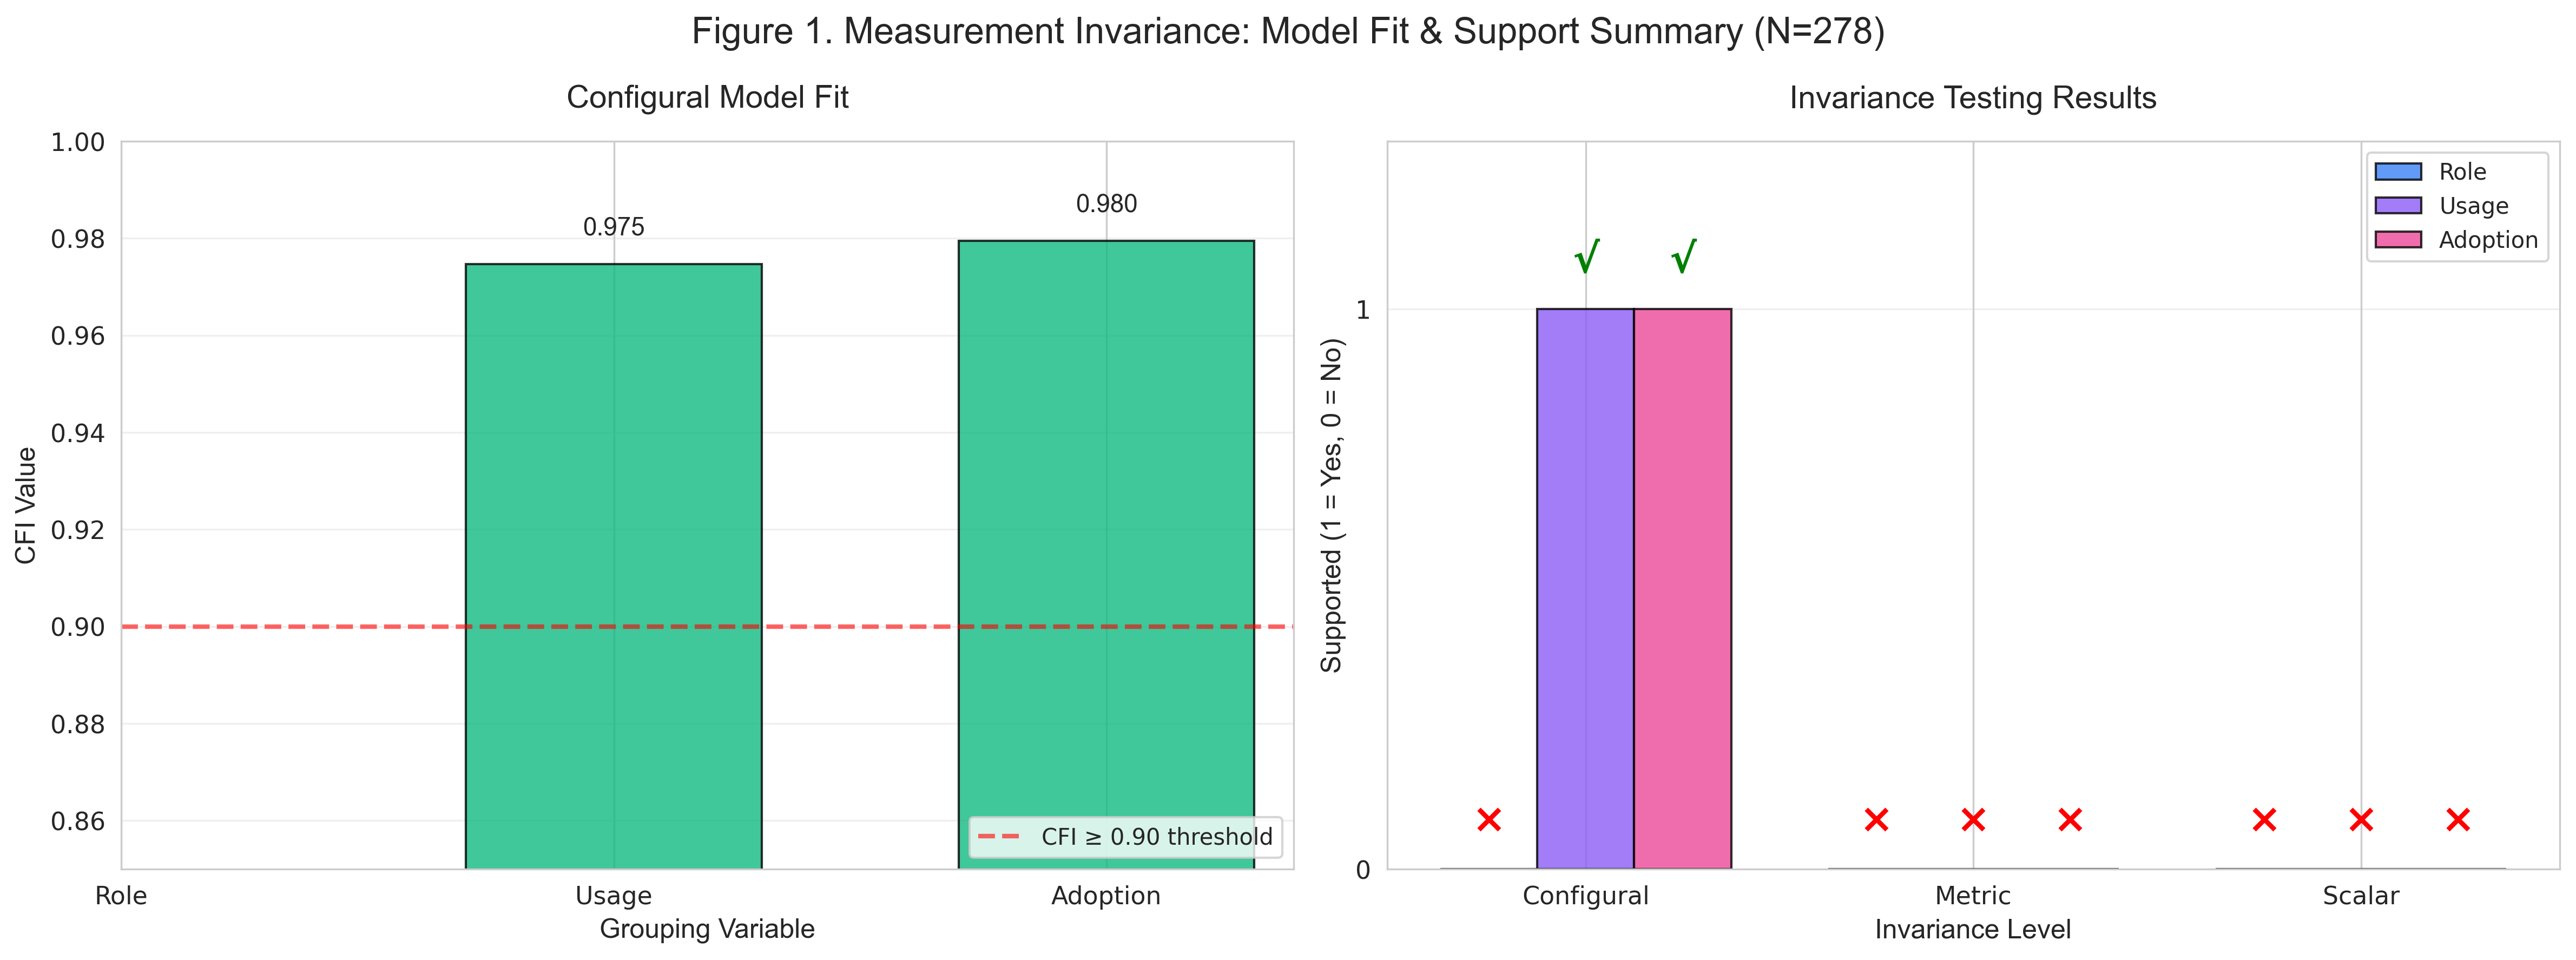


✅ Figure 1 saved: results/plots/invariance_figure1_fit_support.png


In [121]:
# Figure 1: Configural Model Fit & Invariance Decisions

# Extract data for visualization
grouping_vars_viz = ['Role', 'Usage', 'Adoption']
results_dicts_viz = [role_results, usage_results, adoption_results]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Configural CFI Comparison
cfi_values = [results['configural']['CFI'] for results in results_dicts_viz]
x_viz = np.arange(len(grouping_vars_viz))

bars1 = ax1.bar(x_viz, cfi_values, color='#10b981', alpha=0.8, width=0.6, edgecolor='black', linewidth=1)

ax1.axhline(y=0.90, color='red', linestyle='--', linewidth=2, alpha=0.6, label='CFI ≥ 0.90 threshold')

ax1.set_xlabel('Grouping Variable', fontsize=12, family='sans-serif')
ax1.set_ylabel('CFI Value', fontsize=12, family='sans-serif')
ax1.set_title('Configural Model Fit', fontsize=14, family='sans-serif', pad=15)
ax1.set_xticks(x_viz)
ax1.set_xticklabels(grouping_vars_viz, fontsize=11)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim([0.85, 1.0])
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars1, cfi_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontsize=11, family='sans-serif')

# Panel 2: Invariance Support Summary
invariance_levels = ['Configural', 'Metric', 'Scalar']
support_data = []

for group, results in zip(grouping_vars_viz, results_dicts_viz):
    support_data.append([
        1 if results['configural']['CFI'] >= 0.90 else 0,
        1 if results['metric']['holds'] else 0,
        1 if results['scalar']['holds'] else 0
    ])

support_array = np.array(support_data)
x2_viz = np.arange(len(invariance_levels))
width = 0.25

colors = ['#3b82f6', '#8b5cf6', '#ec4899']
for i, (group, color) in enumerate(zip(grouping_vars_viz, colors)):
    offset = (i - 1) * width
    bars = ax2.bar(x2_viz + offset, support_array[i], width, label=group, color=color, alpha=0.8, edgecolor='black', linewidth=1)
    
    for j, (bar, val) in enumerate(zip(bars, support_array[i])):
        symbol = '√' if val == 1 else '×'
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                symbol, ha='center', va='bottom', fontsize=18, fontweight='bold',
                color='green' if val == 1 else 'red')

ax2.set_xlabel('Invariance Level', fontsize=12, family='sans-serif')
ax2.set_ylabel('Supported (1 = Yes, 0 = No)', fontsize=12, family='sans-serif')
ax2.set_title('Invariance Testing Results', fontsize=14, family='sans-serif', pad=15)
ax2.set_xticks(x2_viz)
ax2.set_xticklabels(invariance_levels, fontsize=11)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([0, 1.3])
ax2.set_yticks([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Dynamic title
fig.suptitle(f'Figure 1. Measurement Invariance: Model Fit & Support Summary (N={n_sample})', 
             fontsize=16, family='sans-serif', y=0.98)
             
plt.tight_layout()
plt.savefig('../results/plots/invariance_figure1_fit_support.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 1 saved: results/plots/invariance_figure1_fit_support.png")

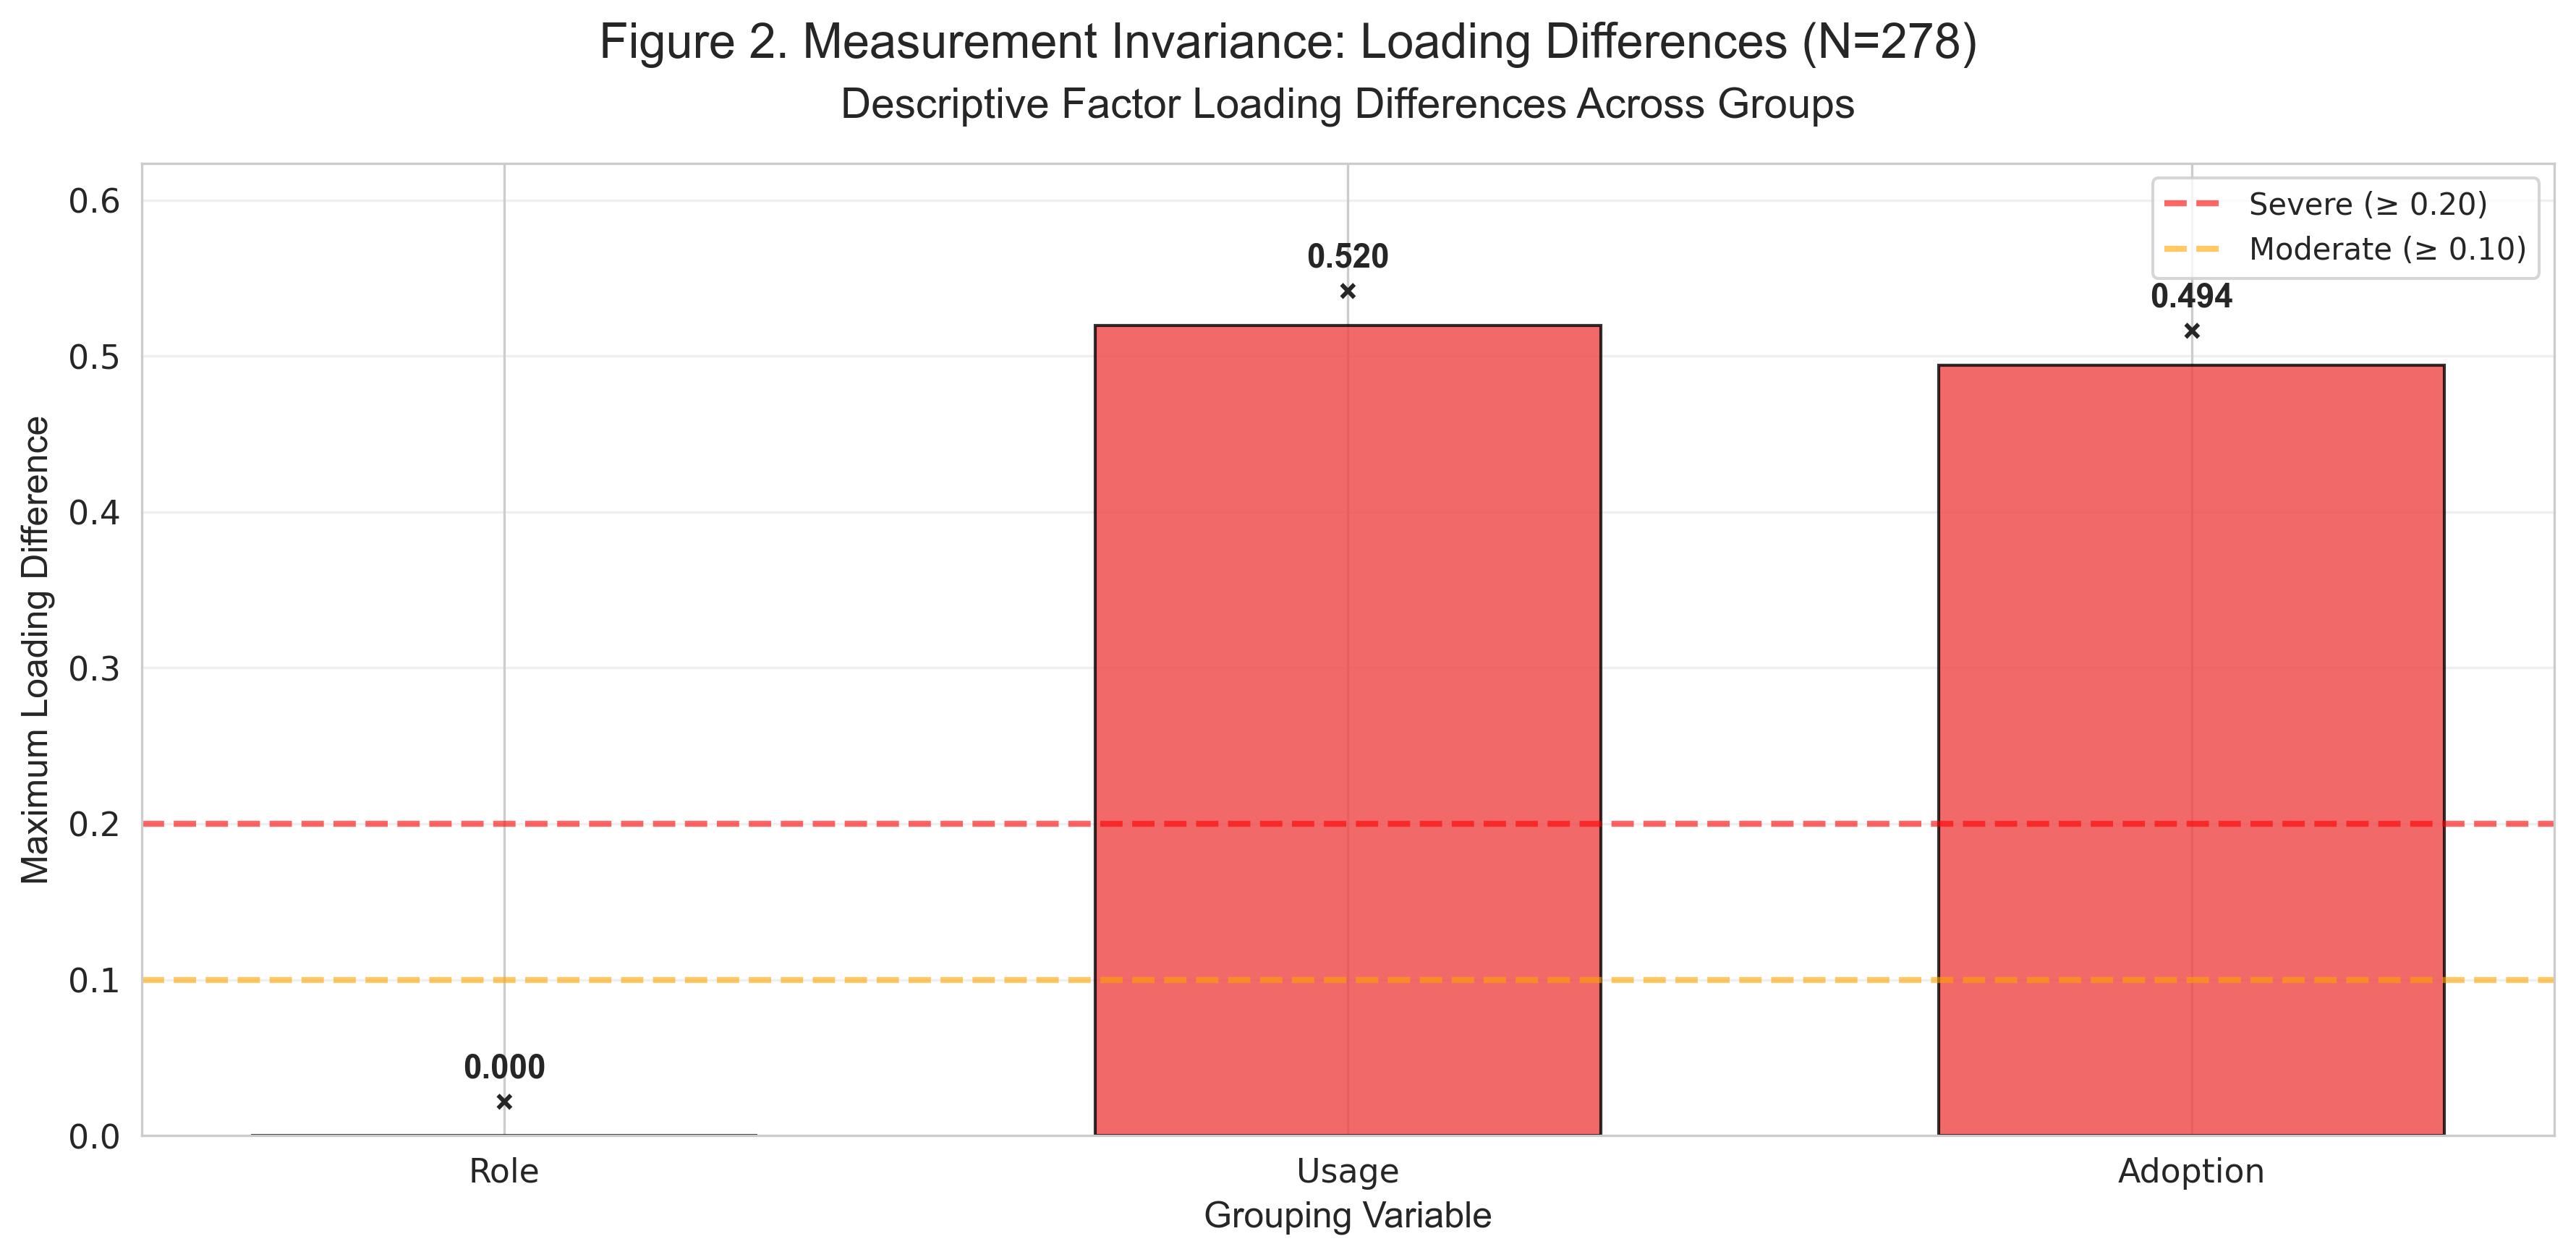


✅ Figure 2 saved: results/plots/invariance_figure2_loading_differences.png


In [122]:
# Figure 2: Maximum Factor Loading Differences

# Extract max loading differences
max_diffs = []
for group, results in zip(grouping_vars_viz, results_dicts_viz):
    max_diffs.append({
        'Group': group,
        'Max_Diff': results['metric']['max_diff'],
        'Metric_Holds': '√' if results['metric']['holds'] else '×'
    })

max_diff_df = pd.DataFrame(max_diffs)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(grouping_vars_viz))
colors_diff = ['#ef4444' if md['Max_Diff'] > 0.20 else '#f59e0b' if md['Max_Diff'] > 0.10 else '#10b981' for md in max_diffs]
bars = ax.bar(x, max_diff_df['Max_Diff'], color=colors_diff, alpha=0.8, width=0.6, edgecolor='black', linewidth=1)

# Add threshold lines
ax.axhline(y=0.20, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Severe (≥ 0.20)')
ax.axhline(y=0.10, color='orange', linestyle='--', linewidth=2, alpha=0.6, label='Moderate (≥ 0.10)')

ax.set_xlabel('Grouping Variable', fontsize=12, family='sans-serif')
ax.set_ylabel('Maximum Loading Difference', fontsize=12, family='sans-serif')
ax.set_title('Descriptive Factor Loading Differences Across Groups', 
             fontsize=14, family='sans-serif', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(grouping_vars_viz, fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, max(max_diff_df['Max_Diff']) * 1.2])

for bar, val, status in zip(bars, max_diff_df['Max_Diff'], max_diff_df['Metric_Holds']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}\n{status}', ha='center', va='bottom', 
            fontsize=11, family='sans-serif', fontweight='bold')

fig.suptitle(f'Figure 2. Measurement Invariance: Loading Differences (N={n_sample})', 
             fontsize=16, family='sans-serif', y=0.96)
             
plt.tight_layout()
plt.savefig('../results/plots/invariance_figure2_loading_differences.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 2 saved: results/plots/invariance_figure2_loading_differences.png")

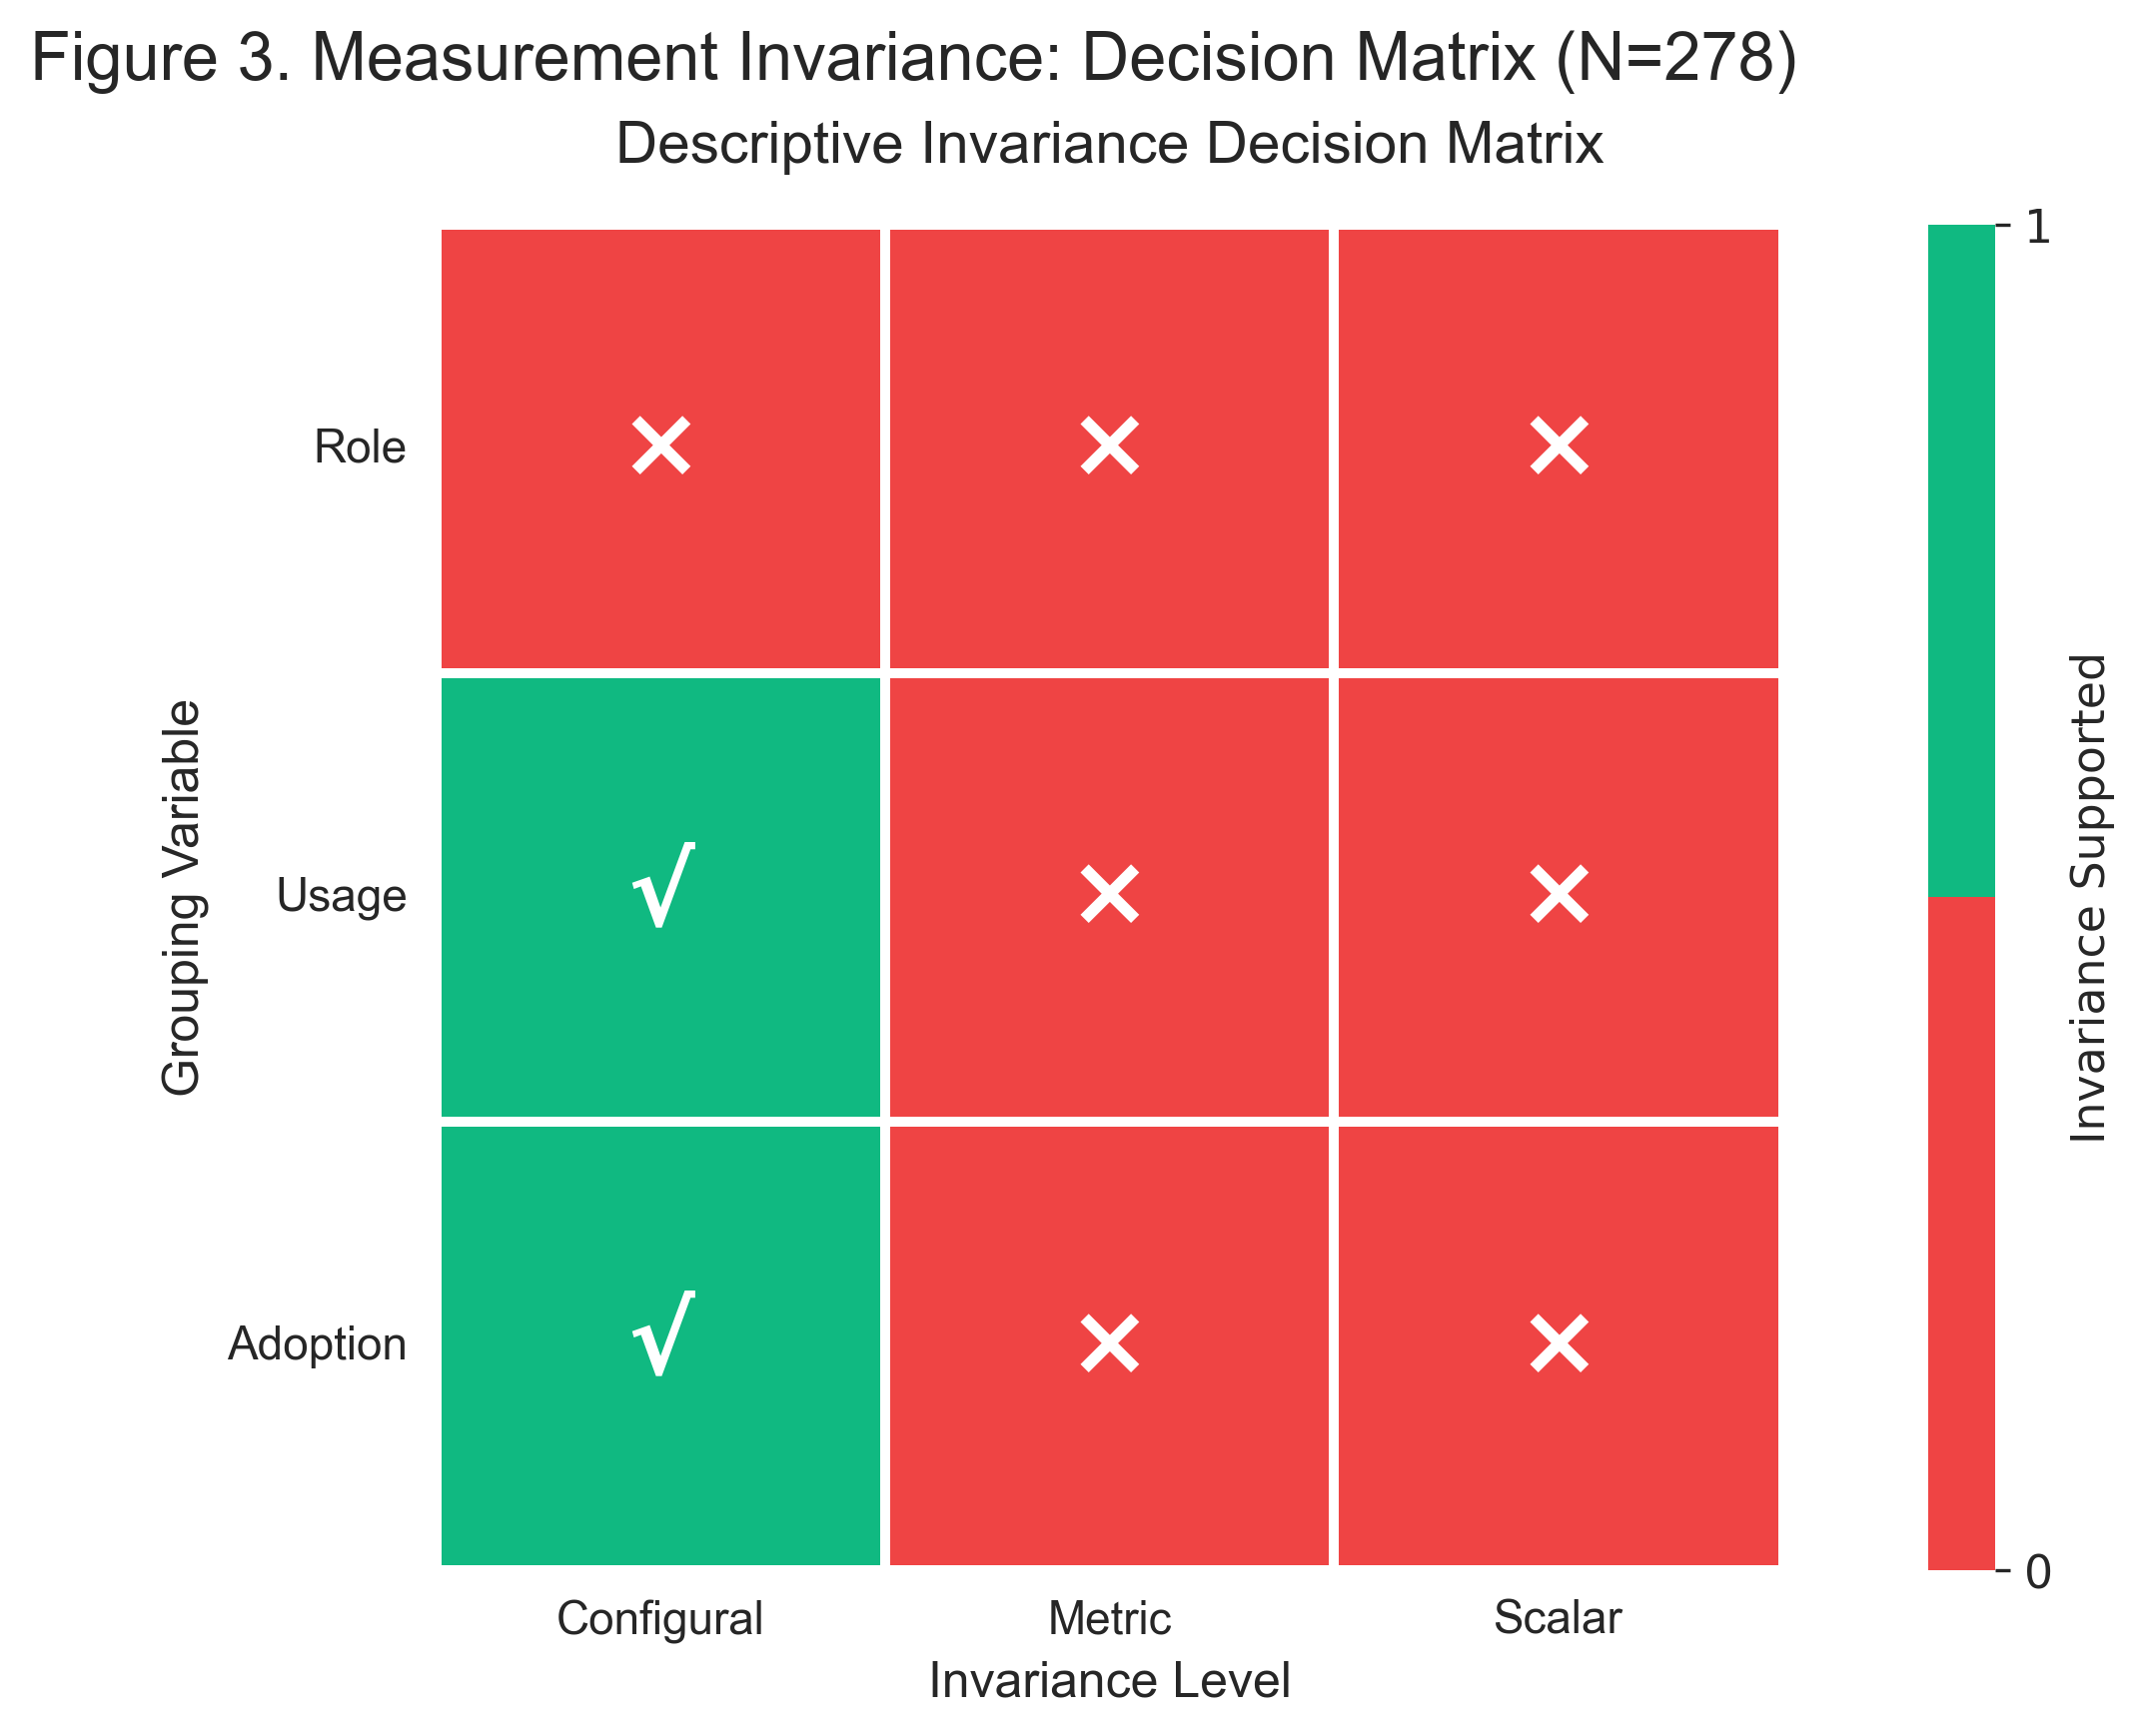


✅ Figure 3 saved: results/plots/invariance_figure3_decision_matrix.png


In [123]:
# Figure 3: Invariance Decision Matrix

# Create decision matrix
decision_data_viz = []
for group, results in zip(grouping_vars_viz, results_dicts_viz):
    decision_data_viz.append({
        'Grouping': group,
        'Configural': 1 if results['configural']['CFI'] >= 0.90 else 0,
        'Metric': 1 if results['metric']['holds'] else 0,
        'Scalar': 1 if results['scalar']['holds'] else 0
    })

decision_df_viz = pd.DataFrame(decision_data_viz).set_index('Grouping')

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))

cmap = sns.color_palette(["#ef4444", "#10b981"], as_cmap=True)

sns.heatmap(decision_df_viz, annot=False, fmt='d', cmap=cmap, 
            cbar_kws={'label': 'Invariance Supported', 'ticks': [0, 1]},
            linewidths=2, linecolor='white', square=True, ax=ax,
            vmin=0, vmax=1)

ax.set_title('Descriptive Invariance Decision Matrix', 
             fontsize=14, family='sans-serif', pad=15)
ax.set_xlabel('Invariance Level', fontsize=12, family='sans-serif')
ax.set_ylabel('Grouping Variable', fontsize=12, family='sans-serif')

plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=11, family='sans-serif')
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=11, family='sans-serif')

# Add checkmarks/crosses
for i, group in enumerate(decision_df_viz.index):
    for j, col in enumerate(decision_df_viz.columns):
        value = decision_df_viz.loc[group, col]
        symbol = '√' if value == 1 else '×'
        ax.text(j + 0.5, i + 0.5, symbol, ha='center', va='center', 
               fontsize=24, fontweight='bold', color='white')

fig.suptitle(f'Figure 3. Measurement Invariance: Decision Matrix (N={n_sample})', 
             fontsize=16, family='sans-serif', y=0.96)
             
plt.tight_layout()
plt.savefig('../results/plots/invariance_figure3_decision_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 3 saved: results/plots/invariance_figure3_decision_matrix.png")

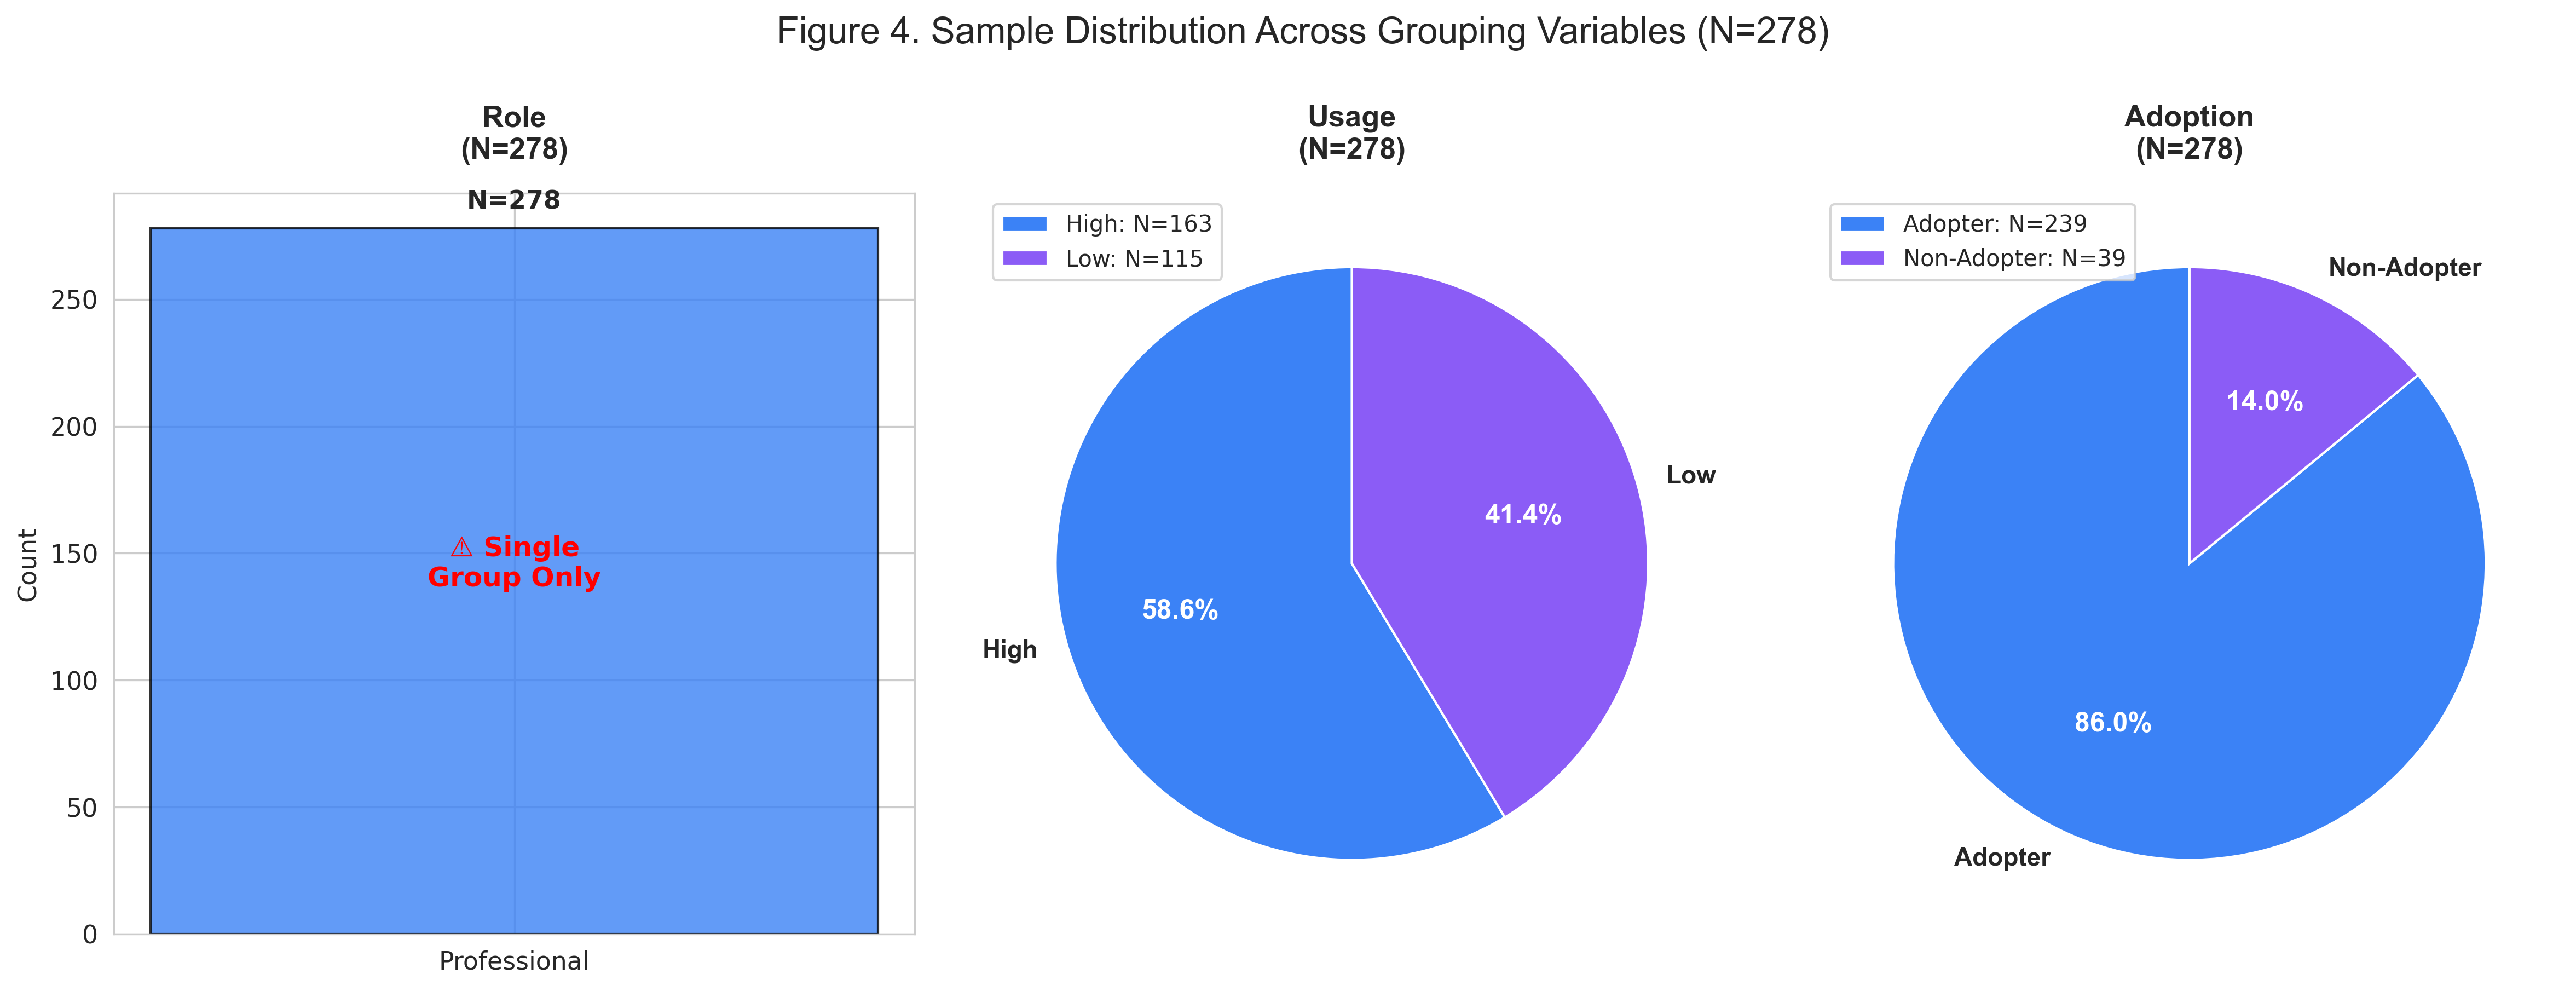


✅ Figure 4 saved: results/plots/invariance_figure4_sample_distribution.png


In [124]:
# Figure 4: Sample Distribution Across Groups

# Prepare sample size data - handle cases where only one group exists
sample_data = []
group_counts = [
    ('Role', role_counts),
    ('Usage', usage_counts),
    ('Adoption', adoption_counts)
]

for grouping, counts in group_counts:
    if len(counts) >= 2:
        sample_data.append({
            'Grouping': grouping,
            'Group1': counts.iloc[0],
            'Group2': counts.iloc[1],
            'Label1': counts.index[0],
            'Label2': counts.index[1]
        })
    else:
        # Only one group - create placeholder
        sample_data.append({
            'Grouping': grouping,
            'Group1': counts.iloc[0],
            'Group2': 0,
            'Label1': counts.index[0],
            'Label2': 'N/A'
        })

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

colors = ['#3b82f6', '#8b5cf6']

for idx, (data, ax, (grouping, counts)) in enumerate(zip(sample_data, axes, group_counts)):
    if len(counts) >= 2:
        # Two groups - create pie chart
        values = [data['Group1'], data['Group2']]
        labels = [data['Label1'], data['Label2']]
        
        wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90,
                                            textprops={'fontsize': 11, 'fontweight': 'bold', 'family': 'sans-serif'})
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')
        
        legend_labels = [f"{label}: N={value}" for label, value in zip(labels, values)]
        ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=10)
    else:
        # Single group - create bar chart instead
        ax.bar([0], [data['Group1']], color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
        ax.set_xticks([0])
        ax.set_xticklabels([data['Label1']], fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.text(0, data['Group1'] + data['Group1']*0.02, f"N={data['Group1']}", 
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.text(0.5, 0.5, '⚠️ Single\nGroup Only', 
                transform=ax.transAxes, ha='center', va='center',
                fontsize=12, color='red', fontweight='bold')
    
    ax.set_title(f"{data['Grouping']}\n(N={data['Group1'] + data['Group2']})", 
                fontsize=13, fontweight='bold', family='sans-serif', pad=15)

fig.suptitle(f'Figure 4. Sample Distribution Across Grouping Variables (N={n_sample})', 
             fontsize=16, family='sans-serif', y=1.00)
plt.tight_layout()
plt.savefig('../results/plots/invariance_figure4_sample_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 4 saved: results/plots/invariance_figure4_sample_distribution.png")

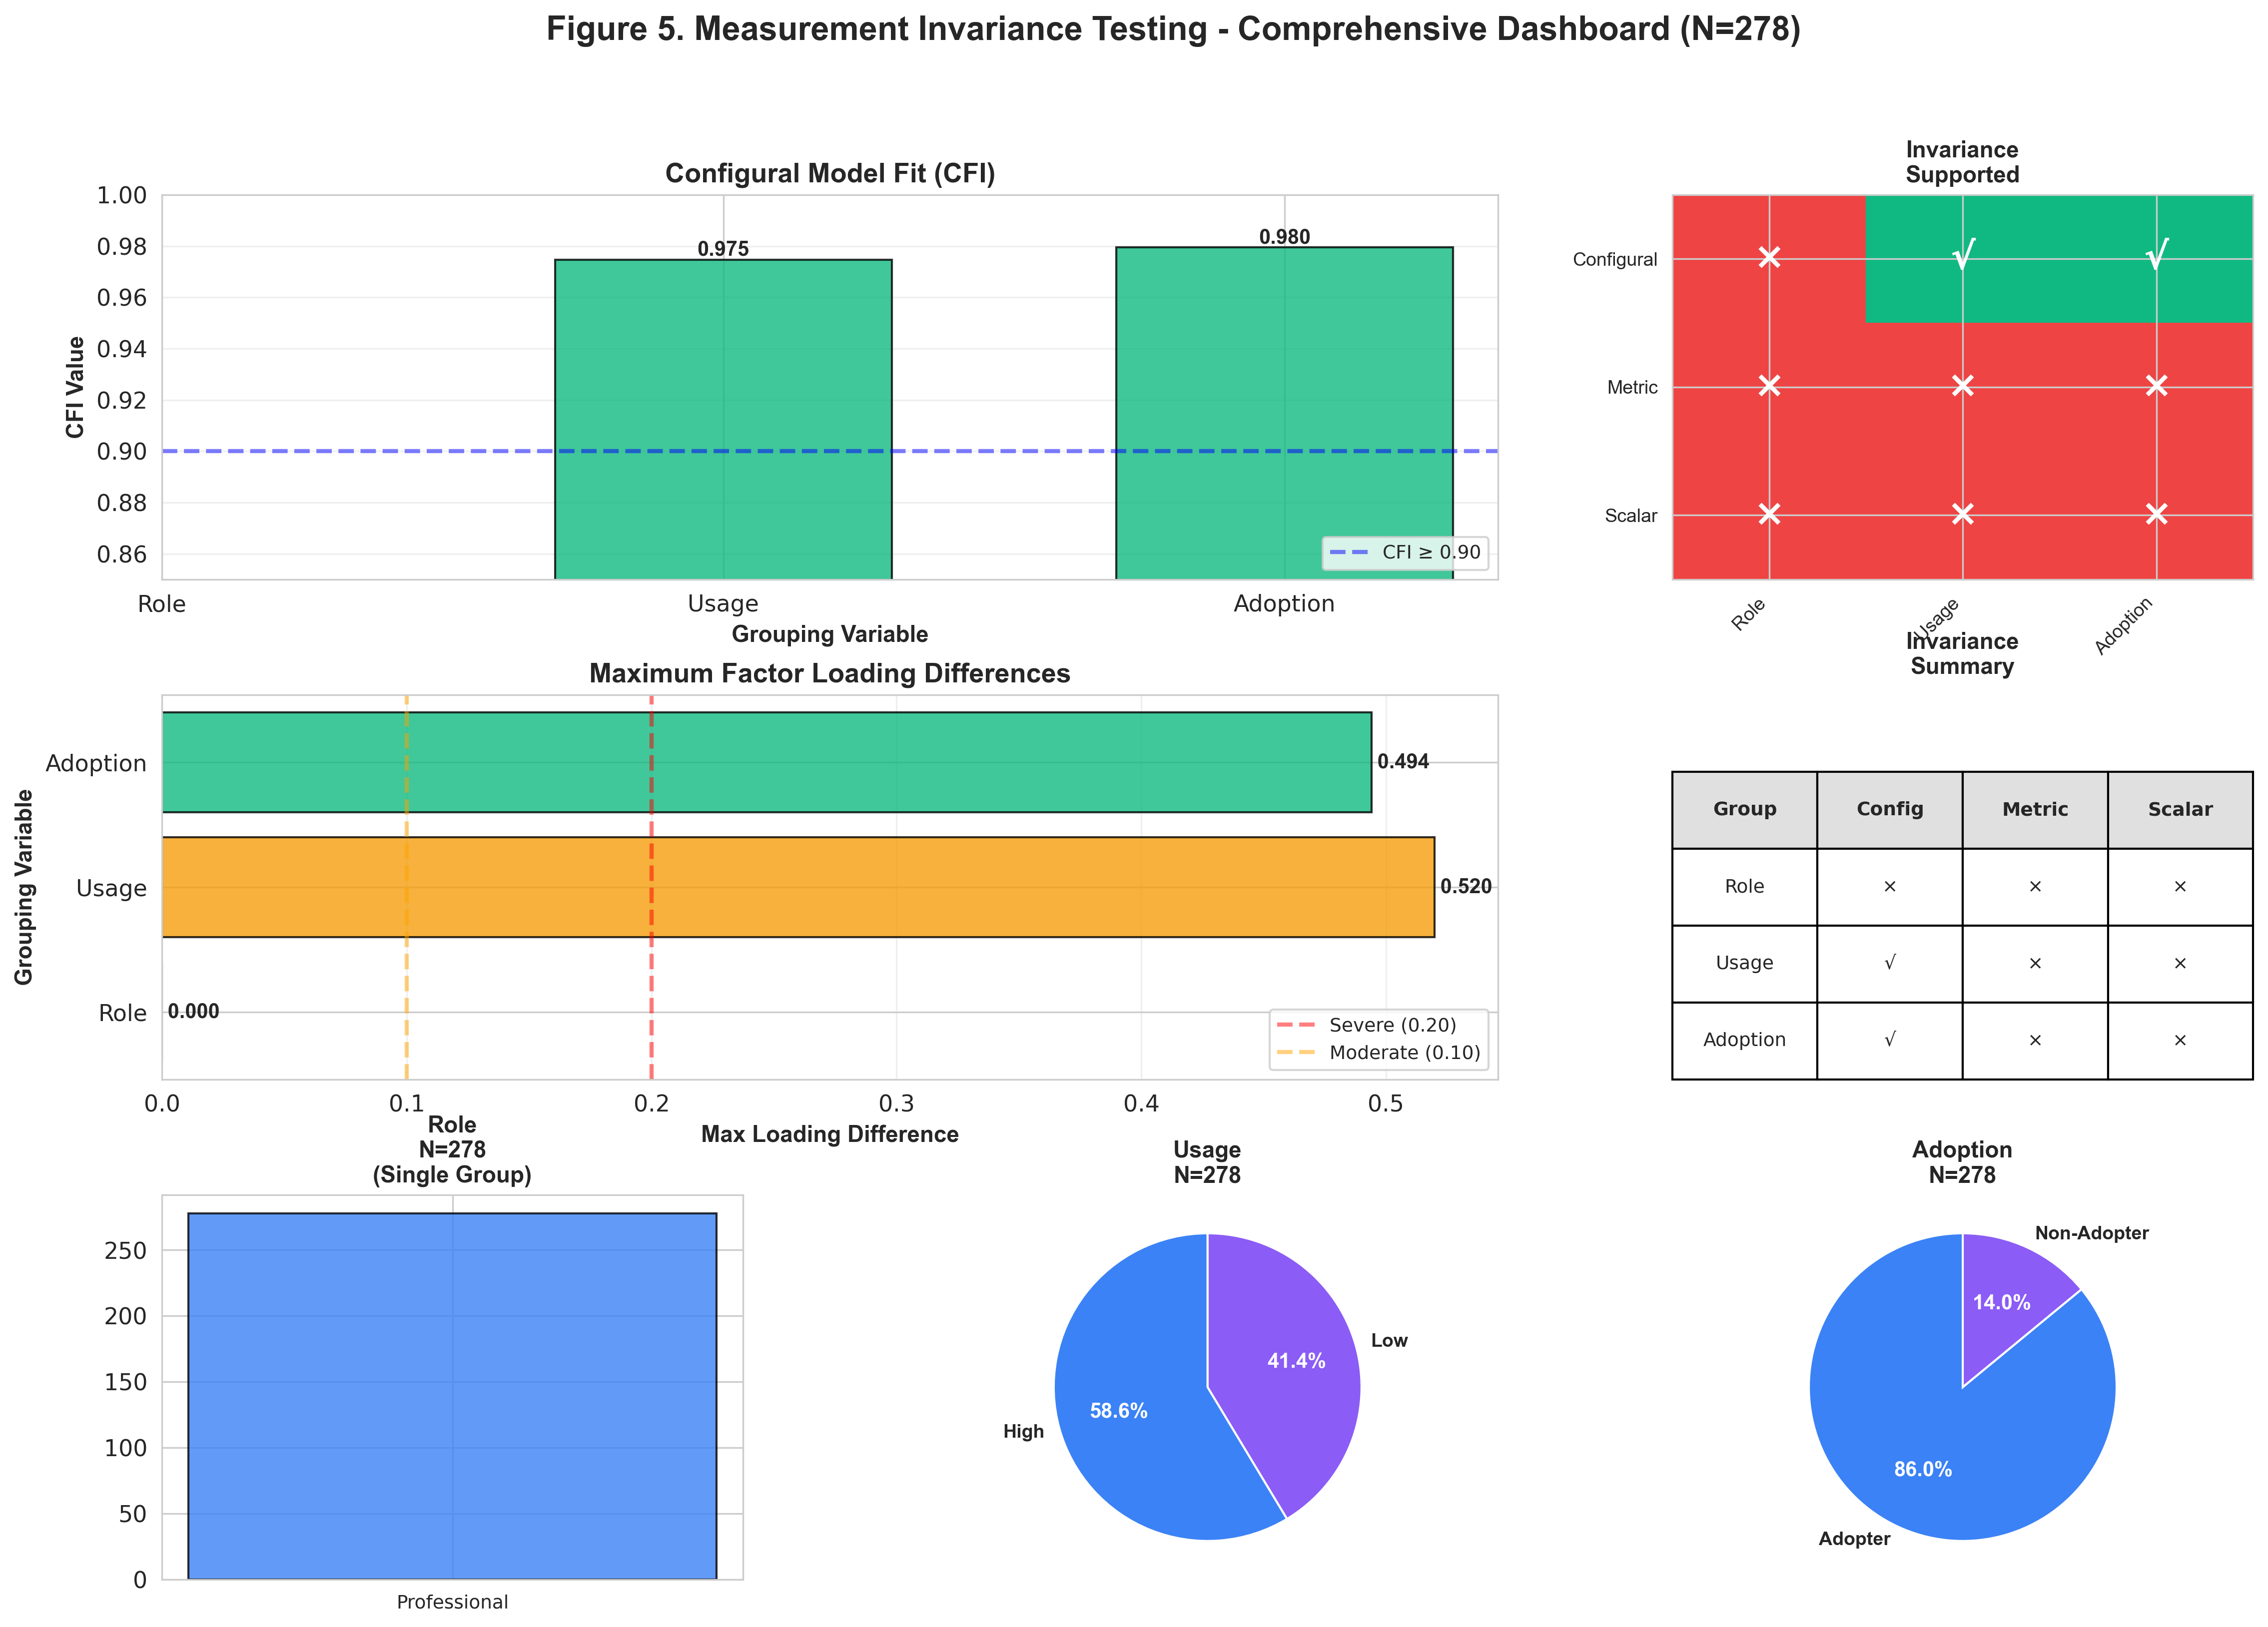


✅ Figure 5 saved: results/plots/invariance_figure5_dashboard.png

📊 All visualization figures generated successfully!


In [125]:
# Figure 5: Comprehensive Invariance Summary Dashboard

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Extract all data first
cfi_vals = [r['configural']['CFI'] for r in results_dicts_viz]
support_config = [1 if r['configural']['CFI'] >= 0.90 else 0 for r in results_dicts_viz]
support_metric = [1 if r['metric']['holds'] else 0 for r in results_dicts_viz]
support_scalar = [1 if r['scalar']['holds'] else 0 for r in results_dicts_viz]

# Panel 1: Configural CFI Bar Chart (Top Left - spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
x1 = np.arange(len(grouping_vars_viz))
bars1 = ax1.bar(x1, cfi_vals, color='#10b981', alpha=0.8, width=0.6, edgecolor='black', linewidth=1)
ax1.axhline(y=0.90, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='CFI ≥ 0.90')
ax1.set_xlabel('Grouping Variable', fontsize=11, fontweight='bold', family='sans-serif')
ax1.set_ylabel('CFI Value', fontsize=11, fontweight='bold', family='sans-serif')
ax1.set_title('Configural Model Fit (CFI)', fontsize=13, fontweight='bold', family='sans-serif')
ax1.set_xticks(x1)
ax1.set_xticklabels(grouping_vars_viz)
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim([0.85, 1.0])
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, cfi_vals):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', family='sans-serif')

# Panel 2: Invariance Support Matrix (Top Right)
ax2 = fig.add_subplot(gs[0, 2])
support_matrix = np.array([support_config, support_metric, support_scalar])
from matplotlib.colors import ListedColormap
cmap_dash = ListedColormap(["#ef4444", "#10b981"])
im = ax2.imshow(support_matrix, cmap=cmap_dash, aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(np.arange(len(grouping_vars_viz)))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(grouping_vars_viz, fontsize=9, family='sans-serif')
ax2.set_yticklabels(['Configural', 'Metric', 'Scalar'], fontsize=9, family='sans-serif')
ax2.set_title('Invariance\nSupported', fontsize=11, fontweight='bold', family='sans-serif')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
for i in range(3):
    for j in range(len(grouping_vars_viz)):
        value = support_matrix[i, j]
        symbol = '√' if value == 1 else '×'
        ax2.text(j, i, symbol, ha='center', va='center',
                fontsize=18, fontweight='bold', color='white')

# Panel 3: Max Loading Differences (Middle Left - spans 2 columns)
ax3 = fig.add_subplot(gs[1, :2])
max_diffs_dash = [r['metric']['max_diff'] for r in results_dicts_viz]
bars3 = ax3.barh(grouping_vars_viz, max_diffs_dash, color=['#ef4444', '#f59e0b', '#10b981'], 
                 alpha=0.8, edgecolor='black', linewidth=1)
ax3.axvline(x=0.20, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Severe (0.20)')
ax3.axvline(x=0.10, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate (0.10)')
ax3.set_xlabel('Max Loading Difference', fontsize=11, fontweight='bold', family='sans-serif')
ax3.set_ylabel('Grouping Variable', fontsize=11, fontweight='bold', family='sans-serif')
ax3.set_title('Maximum Factor Loading Differences', fontsize=13, fontweight='bold', family='sans-serif')
ax3.legend(fontsize=9, loc='lower right')
ax3.grid(axis='x', alpha=0.3)
for bar, val in zip(bars3, max_diffs_dash):
    ax3.text(val, bar.get_y() + bar.get_height()/2.,
            f' {val:.3f}', ha='left', va='center', fontsize=10, fontweight='bold', family='sans-serif')

# Panel 4: Invariance Summary Table (Middle Right)
ax4 = fig.add_subplot(gs[1, 2])
ax4.axis('off')
ax4.set_title('Invariance\nSummary', fontsize=11, fontweight='bold', family='sans-serif', pad=10)
table_data = []
for i, group in enumerate(grouping_vars_viz):
    table_data.append([
        group,
        '√' if support_config[i] else '×',
        '√' if support_metric[i] else '×',
        '√' if support_scalar[i] else '×'
    ])
table = ax4.table(cellText=table_data, colLabels=['Group', 'Config', 'Metric', 'Scalar'],
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#e0e0e0')
        cell.set_text_props(weight='bold')

# Panel 5: Sample Distribution - Role (Bottom Left)
ax5 = fig.add_subplot(gs[2, 0])
if len(role_counts) >= 2:
    role_vals = [role_counts.iloc[0], role_counts.iloc[1]]
    role_labs = [role_counts.index[0], role_counts.index[1]]
    wedges5, texts5, autotexts5 = ax5.pie(role_vals, labels=role_labs, autopct='%1.1f%%',
                                            colors=['#3b82f6', '#8b5cf6'], startangle=90,
                                            textprops={'fontsize': 9, 'fontweight': 'bold', 'family': 'sans-serif'})
    for autotext in autotexts5:
        autotext.set_color('white')
        autotext.set_fontsize(10)
    ax5.set_title(f"Role\nN={sum(role_vals)}", fontsize=11, fontweight='bold', family='sans-serif')
else:
    # Single group - bar chart
    ax5.bar([0], [role_counts.iloc[0]], color='#3b82f6', alpha=0.8, edgecolor='black')
    ax5.set_xticks([0])
    ax5.set_xticklabels([role_counts.index[0]], fontsize=9)
    ax5.set_title(f"Role\nN={role_counts.iloc[0]}\n(Single Group)", fontsize=11, fontweight='bold', family='sans-serif')

# Panel 6: Sample Distribution - Usage (Bottom Middle)
ax6 = fig.add_subplot(gs[2, 1])
if len(usage_counts) >= 2:
    usage_vals = [usage_counts.iloc[0], usage_counts.iloc[1]]
    usage_labs = [usage_counts.index[0], usage_counts.index[1]]
    wedges6, texts6, autotexts6 = ax6.pie(usage_vals, labels=usage_labs, autopct='%1.1f%%',
                                            colors=['#3b82f6', '#8b5cf6'], startangle=90,
                                            textprops={'fontsize': 9, 'fontweight': 'bold', 'family': 'sans-serif'})
    for autotext in autotexts6:
        autotext.set_color('white')
        autotext.set_fontsize(10)
    ax6.set_title(f"Usage\nN={sum(usage_vals)}", fontsize=11, fontweight='bold', family='sans-serif')
else:
    # Single group - bar chart
    ax6.bar([0], [usage_counts.iloc[0]], color='#3b82f6', alpha=0.8, edgecolor='black')
    ax6.set_xticks([0])
    ax6.set_xticklabels([usage_counts.index[0]], fontsize=9)
    ax6.set_title(f"Usage\nN={usage_counts.iloc[0]}\n(Single Group)", fontsize=11, fontweight='bold', family='sans-serif')

# Panel 7: Sample Distribution - Adoption (Bottom Right)
ax7 = fig.add_subplot(gs[2, 2])
if len(adoption_counts) >= 2:
    adoption_vals = [adoption_counts.iloc[0], adoption_counts.iloc[1]]
    adoption_labs = [adoption_counts.index[0], adoption_counts.index[1]]
    wedges7, texts7, autotexts7 = ax7.pie(adoption_vals, labels=adoption_labs, autopct='%1.1f%%',
                                            colors=['#3b82f6', '#8b5cf6'], startangle=90,
                                            textprops={'fontsize': 9, 'fontweight': 'bold', 'family': 'sans-serif'})
    for autotext in autotexts7:
        autotext.set_color('white')
        autotext.set_fontsize(10)
    ax7.set_title(f"Adoption\nN={sum(adoption_vals)}", fontsize=11, fontweight='bold', family='sans-serif')
else:
    # Single group - bar chart
    ax7.bar([0], [adoption_counts.iloc[0]], color='#3b82f6', alpha=0.8, edgecolor='black')
    ax7.set_xticks([0])
    ax7.set_xticklabels([adoption_counts.index[0]], fontsize=9)
    ax7.set_title(f"Adoption\nN={adoption_counts.iloc[0]}\n(Single Group)", fontsize=11, fontweight='bold', family='sans-serif')

# Overall title with dynamic sample size
fig.suptitle(f'Figure 5. Measurement Invariance Testing - Comprehensive Dashboard (N={n_sample})',
            fontsize=16, fontweight='bold', family='sans-serif', y=0.98)

plt.savefig('../results/plots/invariance_figure5_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 5 saved: results/plots/invariance_figure5_dashboard.png")
print("\n" + "="*80)
print("📊 All visualization figures generated successfully!")
print("="*80)